In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 5
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['solar_activity'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 20
n_seq (number of output/future prediction time steps): 5
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     8000

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

5
20
(19, 225)
(2, 225)


[I 2025-06-08 06:18:32,323] A new study created in memory with name: no-name-c43b00d5-cfb9-4174-a4b0-e67725b50cc0
[I 2025-06-08 06:23:12,006] Trial 0 finished with value: 0.09568005651235581 and parameters: {'lr': 0.0013645369705907226, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.47655555909867975}. Best is trial 0 with value: 0.09568005651235581.


Cross Validation Accuracies:
[0.07153677940368652, 0.12429361790418625, 0.08669734746217728, 0.1298755258321762, 0.06599701195955276]
Mean Cross Validation Accuracy:
0.09568005651235581
Standard Deviation of Cross Validation Accuracy:
0.02658095574984719


[I 2025-06-08 06:27:30,994] Trial 1 finished with value: 0.09648841172456742 and parameters: {'lr': 0.7820329997096148, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.46499295334188806}. Best is trial 0 with value: 0.09568005651235581.


Cross Validation Accuracies:
[0.09759281575679779, 0.11311032623052597, 0.06472384184598923, 0.11251119524240494, 0.09450387954711914]
Mean Cross Validation Accuracy:
0.09648841172456742
Standard Deviation of Cross Validation Accuracy:
0.017590699868417357


[I 2025-06-08 06:32:51,268] Trial 2 finished with value: 0.077892205119133 and parameters: {'lr': 0.02198594012635093, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.33494679657282594}. Best is trial 2 with value: 0.077892205119133.


Cross Validation Accuracies:
[0.0587112158536911, 0.1042381152510643, 0.07336978614330292, 0.09501877427101135, 0.058123134076595306]
Mean Cross Validation Accuracy:
0.077892205119133
Standard Deviation of Cross Validation Accuracy:
0.018796835606413754


[I 2025-06-08 06:37:49,710] Trial 3 finished with value: 0.07822890505194664 and parameters: {'lr': 0.12615606845977995, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.43589958285891617}. Best is trial 2 with value: 0.077892205119133.


Cross Validation Accuracies:
[0.06344902515411377, 0.0982821136713028, 0.07432740181684494, 0.09621403366327286, 0.05887195095419884]
Mean Cross Validation Accuracy:
0.07822890505194664
Standard Deviation of Cross Validation Accuracy:
0.016333733659684508


[I 2025-06-08 06:43:19,082] Trial 4 finished with value: 0.08480236530303956 and parameters: {'lr': 0.04434179138028995, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.39041543888912755}. Best is trial 2 with value: 0.077892205119133.


Cross Validation Accuracies:
[0.1004849374294281, 0.09883257001638412, 0.07267878204584122, 0.09432206302881241, 0.0576934739947319]
Mean Cross Validation Accuracy:
0.08480236530303956
Standard Deviation of Cross Validation Accuracy:
0.01682431345730148


[I 2025-06-08 06:48:52,465] Trial 5 finished with value: 0.5635560691356659 and parameters: {'lr': 0.023125695185283592, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.304577892226527}. Best is trial 2 with value: 0.077892205119133.


Cross Validation Accuracies:
[0.6478480100631714, 0.4975937306880951, 0.5103353261947632, 0.5126953721046448, 0.649307906627655]
Mean Cross Validation Accuracy:
0.5635560691356659
Standard Deviation of Cross Validation Accuracy:
0.06961148901397446


[I 2025-06-08 06:54:48,237] Trial 6 finished with value: 0.11304791271686554 and parameters: {'lr': 0.00356123094999165, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1749742663629602}. Best is trial 2 with value: 0.077892205119133.


Cross Validation Accuracies:
[0.0758531242609024, 0.1067659929394722, 0.09478013962507248, 0.16211456060409546, 0.12572574615478516]
Mean Cross Validation Accuracy:
0.11304791271686554
Standard Deviation of Cross Validation Accuracy:
0.02941050742056563


[I 2025-06-08 06:59:54,894] Trial 7 finished with value: 0.1073014721274376 and parameters: {'lr': 0.33633105609866454, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.29359674797148927}. Best is trial 2 with value: 0.077892205119133.


Cross Validation Accuracies:
[0.06885392218828201, 0.10227713733911514, 0.11457141488790512, 0.13310344517230988, 0.1177014410495758]
Mean Cross Validation Accuracy:
0.1073014721274376
Standard Deviation of Cross Validation Accuracy:
0.021588011815446277


[I 2025-06-08 07:06:07,040] Trial 8 finished with value: 0.09200291782617569 and parameters: {'lr': 0.0017213149705098895, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.48840473898233006}. Best is trial 2 with value: 0.077892205119133.


Cross Validation Accuracies:
[0.07611396908760071, 0.11922068148851395, 0.08510670810937881, 0.11144661158323288, 0.0681266188621521]
Mean Cross Validation Accuracy:
0.09200291782617569
Standard Deviation of Cross Validation Accuracy:
0.01994471327641321


[I 2025-06-08 07:10:49,819] Trial 9 finished with value: 0.34347572922706604 and parameters: {'lr': 0.0025050352150256935, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.39693433681347745}. Best is trial 2 with value: 0.077892205119133.


Cross Validation Accuracies:
[0.28685835003852844, 0.31176745891571045, 0.3061732351779938, 0.4959525167942047, 0.3166270852088928]
Mean Cross Validation Accuracy:
0.34347572922706604
Standard Deviation of Cross Validation Accuracy:
0.07690570658541099


[I 2025-06-08 07:15:33,323] Trial 10 finished with value: 0.07901871502399445 and parameters: {'lr': 0.01108174663708297, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.13314830923551765}. Best is trial 2 with value: 0.077892205119133.


Cross Validation Accuracies:
[0.04320149123668671, 0.10737603157758713, 0.07948751747608185, 0.09003124386072159, 0.07499729096889496]
Mean Cross Validation Accuracy:
0.07901871502399445
Standard Deviation of Cross Validation Accuracy:
0.021093498242351873


[I 2025-06-08 07:20:38,043] Trial 11 finished with value: 0.0765295036137104 and parameters: {'lr': 0.1349423010357535, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3237136962098051}. Best is trial 11 with value: 0.0765295036137104.


Cross Validation Accuracies:
[0.06092783063650131, 0.09700419008731842, 0.07212062925100327, 0.09464986622333527, 0.05794500187039375]
Mean Cross Validation Accuracy:
0.0765295036137104
Standard Deviation of Cross Validation Accuracy:
0.016466902593858326


[I 2025-06-08 07:25:51,357] Trial 12 finished with value: 0.07640700191259384 and parameters: {'lr': 0.13511112515096385, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.29770501026504725}. Best is trial 12 with value: 0.07640700191259384.


Cross Validation Accuracies:
[0.05939280986785889, 0.09681567549705505, 0.07354528456926346, 0.09447624534368515, 0.05780499428510666]
Mean Cross Validation Accuracy:
0.07640700191259384
Standard Deviation of Cross Validation Accuracy:
0.016653638404327462


[I 2025-06-08 07:30:50,318] Trial 13 finished with value: 0.07651041522622108 and parameters: {'lr': 0.17880575430871443, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.22827626599960688}. Best is trial 12 with value: 0.07640700191259384.


Cross Validation Accuracies:
[0.059297770261764526, 0.09678534418344498, 0.07374057918787003, 0.09428457170724869, 0.058443810790777206]
Mean Cross Validation Accuracy:
0.07651041522622108
Standard Deviation of Cross Validation Accuracy:
0.0164763024796895


[I 2025-06-08 07:35:37,373] Trial 14 finished with value: 0.07632126659154892 and parameters: {'lr': 0.09763901123674336, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.22743156215391339}. Best is trial 14 with value: 0.07632126659154892.


Cross Validation Accuracies:
[0.059225235134363174, 0.0969887301325798, 0.07141108810901642, 0.09652015566825867, 0.057461123913526535]
Mean Cross Validation Accuracy:
0.07632126659154892
Standard Deviation of Cross Validation Accuracy:
0.017362190502951153


[I 2025-06-08 07:40:32,471] Trial 15 finished with value: 0.569512563943863 and parameters: {'lr': 0.05948422147816734, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.22555019022654593}. Best is trial 14 with value: 0.07632126659154892.


Cross Validation Accuracies:
[0.7211673259735107, 0.380121648311615, 0.6708237528800964, 0.4971109926700592, 0.5783390998840332]
Mean Cross Validation Accuracy:
0.569512563943863
Standard Deviation of Cross Validation Accuracy:
0.12202617590794392


[I 2025-06-08 07:45:36,284] Trial 16 finished with value: 0.07729574963450432 and parameters: {'lr': 0.5765455160155132, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.24469248434394406}. Best is trial 14 with value: 0.07632126659154892.


Cross Validation Accuracies:
[0.059820063412189484, 0.09709099680185318, 0.07261909544467926, 0.09843802452087402, 0.058510567992925644]
Mean Cross Validation Accuracy:
0.07729574963450432
Standard Deviation of Cross Validation Accuracy:
0.01742986718507269


[I 2025-06-08 07:50:51,079] Trial 17 finished with value: 0.07685033679008484 and parameters: {'lr': 0.008481145123930339, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.17396384378877977}. Best is trial 14 with value: 0.07632126659154892.


Cross Validation Accuracies:
[0.06400370597839355, 0.09590212255716324, 0.07276275753974915, 0.09384388476610184, 0.05773921310901642]
Mean Cross Validation Accuracy:
0.07685033679008484
Standard Deviation of Cross Validation Accuracy:
0.015483736560795701


[I 2025-06-08 07:55:49,998] Trial 18 finished with value: 0.5887370795011521 and parameters: {'lr': 0.07601919610901244, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.2686358169063446}. Best is trial 14 with value: 0.07632126659154892.


Cross Validation Accuracies:
[0.5877399444580078, 0.5558660626411438, 0.5488474369049072, 1.0555765628814697, 0.19565539062023163]
Mean Cross Validation Accuracy:
0.5887370795011521
Standard Deviation of Cross Validation Accuracy:
0.273906918127469


[I 2025-06-08 08:01:14,048] Trial 19 finished with value: 1.2966781258583069 and parameters: {'lr': 0.28106054752892917, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.38741809477594796}. Best is trial 14 with value: 0.07632126659154892.


Cross Validation Accuracies:
[1.33570396900177, 1.1874661445617676, 0.496833860874176, 0.8339422941207886, 2.6294443607330322]
Mean Cross Validation Accuracy:
1.2966781258583069
Standard Deviation of Cross Validation Accuracy:
0.7271301683076755


[I 2025-06-08 08:06:16,114] Trial 20 finished with value: 0.07659055665135384 and parameters: {'lr': 0.370766301013945, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.19641242595342148}. Best is trial 14 with value: 0.07632126659154892.


Cross Validation Accuracies:
[0.05904350429773331, 0.09718980640172958, 0.07224754989147186, 0.0957261249423027, 0.05874579772353172]
Mean Cross Validation Accuracy:
0.07659055665135384
Standard Deviation of Cross Validation Accuracy:
0.016945177717008993


[I 2025-06-08 08:11:14,418] Trial 21 finished with value: 0.0761606827378273 and parameters: {'lr': 0.11814922266480261, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.12536742716631571}. Best is trial 21 with value: 0.0761606827378273.


Cross Validation Accuracies:
[0.05714854225516319, 0.0969306230545044, 0.07360426336526871, 0.09513381868600845, 0.05798616632819176]
Mean Cross Validation Accuracy:
0.0761606827378273
Standard Deviation of Cross Validation Accuracy:
0.017260823392477847


[I 2025-06-08 08:16:18,293] Trial 22 finished with value: 0.07688118517398834 and parameters: {'lr': 0.08766777711303522, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1063085077097208}. Best is trial 21 with value: 0.0761606827378273.


Cross Validation Accuracies:
[0.060040220618247986, 0.09702898561954498, 0.0728294625878334, 0.09530234336853027, 0.059204913675785065]
Mean Cross Validation Accuracy:
0.07688118517398834
Standard Deviation of Cross Validation Accuracy:
0.016478823071951264


[I 2025-06-08 08:21:35,727] Trial 23 finished with value: 0.07825376987457275 and parameters: {'lr': 0.21821958759352753, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.13328264978144197}. Best is trial 21 with value: 0.0761606827378273.


Cross Validation Accuracies:
[0.06944622844457626, 0.0960606187582016, 0.072850301861763, 0.09288353472948074, 0.06002816557884216]
Mean Cross Validation Accuracy:
0.07825376987457275
Standard Deviation of Cross Validation Accuracy:
0.013928796009888372


[I 2025-06-08 08:26:35,002] Trial 24 finished with value: 0.07683833837509155 and parameters: {'lr': 0.035335785908878606, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.35450380339344534}. Best is trial 21 with value: 0.0761606827378273.


Cross Validation Accuracies:
[0.05977468192577362, 0.09820011258125305, 0.07364094257354736, 0.09461122751235962, 0.05796472728252411]
Mean Cross Validation Accuracy:
0.07683833837509155
Standard Deviation of Cross Validation Accuracy:
0.016910386704781264


[I 2025-06-08 08:31:27,566] Trial 25 finished with value: 0.07682265043258667 and parameters: {'lr': 0.0995320420593679, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2667080106518921}. Best is trial 21 with value: 0.0761606827378273.


Cross Validation Accuracies:
[0.06000624969601631, 0.09691370278596878, 0.07224135100841522, 0.09644604474306107, 0.05850590392947197]
Mean Cross Validation Accuracy:
0.07682265043258667
Standard Deviation of Cross Validation Accuracy:
0.016899768220522447


[I 2025-06-08 08:36:29,237] Trial 26 finished with value: 0.07723832204937935 and parameters: {'lr': 0.4941573561797021, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1993277858878271}. Best is trial 21 with value: 0.0761606827378273.


Cross Validation Accuracies:
[0.061669785529375076, 0.09685204923152924, 0.07466438412666321, 0.09438642114400864, 0.05861897021532059]
Mean Cross Validation Accuracy:
0.07723832204937935
Standard Deviation of Cross Validation Accuracy:
0.015965214342815455


[I 2025-06-08 08:41:35,562] Trial 27 finished with value: 0.07691150605678558 and parameters: {'lr': 0.04995394036760536, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.10027289977156771}. Best is trial 21 with value: 0.0761606827378273.


Cross Validation Accuracies:
[0.059111323207616806, 0.09718724340200424, 0.07644566893577576, 0.0941888615489006, 0.05762443318963051]
Mean Cross Validation Accuracy:
0.07691150605678558
Standard Deviation of Cross Validation Accuracy:
0.01672523381698034


[I 2025-06-08 08:46:42,541] Trial 28 finished with value: 0.9312635779380798 and parameters: {'lr': 0.013805660220745206, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.15916486406569844}. Best is trial 21 with value: 0.0761606827378273.


Cross Validation Accuracies:
[1.0862258672714233, 1.1080219745635986, 0.8121994733810425, 0.8544654250144958, 0.7954051494598389]
Mean Cross Validation Accuracy:
0.9312635779380798
Standard Deviation of Cross Validation Accuracy:
0.13695880531610644


[I 2025-06-08 08:51:36,935] Trial 29 finished with value: 0.14341463148593903 and parameters: {'lr': 0.1888429589628372, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2686052982936309}. Best is trial 21 with value: 0.0761606827378273.


Cross Validation Accuracies:
[0.150616854429245, 0.15722854435443878, 0.12694983184337616, 0.12724420428276062, 0.15503372251987457]
Mean Cross Validation Accuracy:
0.14341463148593903
Standard Deviation of Cross Validation Accuracy:
0.013492752304266895


[I 2025-06-08 08:56:15,223] Trial 30 finished with value: 64.90789172053337 and parameters: {'lr': 0.896985211501159, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.14312327148154264}. Best is trial 21 with value: 0.0761606827378273.


Cross Validation Accuracies:
[322.7121276855469, 0.4752551019191742, 0.43874725699424744, 0.45288482308387756, 0.46044373512268066]
Mean Cross Validation Accuracy:
64.90789172053337
Standard Deviation of Cross Validation Accuracy:
128.90211852174806


[I 2025-06-08 09:02:21,619] Trial 31 finished with value: 0.07673907577991486 and parameters: {'lr': 0.16367369995219339, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.21894190097550087}. Best is trial 21 with value: 0.0761606827378273.


Cross Validation Accuracies:
[0.06011263653635979, 0.09666873514652252, 0.07295532524585724, 0.09508782625198364, 0.05887085571885109]
Mean Cross Validation Accuracy:
0.07673907577991486
Standard Deviation of Cross Validation Accuracy:
0.01639448995564954


[I 2025-06-08 09:06:56,419] Trial 32 finished with value: 0.0765387885272503 and parameters: {'lr': 0.21925607678788603, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.23550586689871503}. Best is trial 21 with value: 0.0761606827378273.


Cross Validation Accuracies:
[0.060447461903095245, 0.097089983522892, 0.0715012326836586, 0.09563270211219788, 0.05802256241440773]
Mean Cross Validation Accuracy:
0.0765387885272503
Standard Deviation of Cross Validation Accuracy:
0.01681717897034335


[I 2025-06-08 09:11:41,418] Trial 33 finished with value: 0.07894517183303833 and parameters: {'lr': 0.10419006104914486, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1987461450045905}. Best is trial 21 with value: 0.0761606827378273.


Cross Validation Accuracies:
[0.06692946702241898, 0.09854274243116379, 0.0748998373746872, 0.09685984253883362, 0.057493969798088074]
Mean Cross Validation Accuracy:
0.07894517183303833
Standard Deviation of Cross Validation Accuracy:
0.01628432474231406


[I 2025-06-08 09:16:39,312] Trial 34 finished with value: 0.07696179375052452 and parameters: {'lr': 0.07054665338570268, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2941669323324111}. Best is trial 21 with value: 0.0761606827378273.


Cross Validation Accuracies:
[0.05962881073355675, 0.09846334159374237, 0.07201489806175232, 0.0967833623290062, 0.05791855603456497]
Mean Cross Validation Accuracy:
0.07696179375052452
Standard Deviation of Cross Validation Accuracy:
0.01756564898029258


[I 2025-06-08 09:21:41,776] Trial 35 finished with value: 0.0761690080165863 and parameters: {'lr': 0.026733602821028112, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.35774394126721676}. Best is trial 21 with value: 0.0761606827378273.


Cross Validation Accuracies:
[0.05881481245160103, 0.09763986617326736, 0.07294096052646637, 0.09438581019639969, 0.05706359073519707]
Mean Cross Validation Accuracy:
0.0761690080165863
Standard Deviation of Cross Validation Accuracy:
0.017143249373703935


[I 2025-06-08 09:26:45,492] Trial 36 finished with value: 0.1045083999633789 and parameters: {'lr': 0.02320934413317206, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.35594714752302586}. Best is trial 21 with value: 0.0761606827378273.


Cross Validation Accuracies:
[0.1017245277762413, 0.11510401219129562, 0.10896036028862, 0.10111940652132034, 0.09563369303941727]
Mean Cross Validation Accuracy:
0.1045083999633789
Standard Deviation of Cross Validation Accuracy:
0.006783547642830349


[I 2025-06-08 09:31:04,702] Trial 37 finished with value: 0.07603911012411117 and parameters: {'lr': 0.036052493100761064, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.32664475357509315}. Best is trial 37 with value: 0.07603911012411117.


Cross Validation Accuracies:
[0.05730491504073143, 0.09776937961578369, 0.07210847735404968, 0.09521307051181793, 0.05779970809817314]
Mean Cross Validation Accuracy:
0.07603911012411117
Standard Deviation of Cross Validation Accuracy:
0.017543894064825316


[I 2025-06-08 09:35:22,832] Trial 38 finished with value: 0.07662730887532235 and parameters: {'lr': 0.03253991946844377, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.43184228153481585}. Best is trial 37 with value: 0.07603911012411117.


Cross Validation Accuracies:
[0.060880791395902634, 0.09855489432811737, 0.07209709286689758, 0.09377413988113403, 0.05782962590456009]
Mean Cross Validation Accuracy:
0.07662730887532235
Standard Deviation of Cross Validation Accuracy:
0.01671323650412114


[I 2025-06-08 09:40:09,798] Trial 39 finished with value: 0.07637756168842316 and parameters: {'lr': 0.005955944720145788, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3345073868764126}. Best is trial 37 with value: 0.07603911012411117.


Cross Validation Accuracies:
[0.05963708832859993, 0.09716085344552994, 0.07260945439338684, 0.09453153610229492, 0.05794887617230415]
Mean Cross Validation Accuracy:
0.07637756168842316
Standard Deviation of Cross Validation Accuracy:
0.016706708437214102


[I 2025-06-08 09:44:59,203] Trial 40 finished with value: 0.07666899487376214 and parameters: {'lr': 0.015244960669195454, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.37034622148414004}. Best is trial 37 with value: 0.07603911012411117.


Cross Validation Accuracies:
[0.060993846505880356, 0.09805843234062195, 0.07295501977205276, 0.09475834667682648, 0.05657932907342911]
Mean Cross Validation Accuracy:
0.07666899487376214
Standard Deviation of Cross Validation Accuracy:
0.017016646221767837


[I 2025-06-08 09:49:47,820] Trial 41 finished with value: 0.0763321951031685 and parameters: {'lr': 0.005863604854825955, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3151259251644726}. Best is trial 37 with value: 0.07603911012411117.


Cross Validation Accuracies:
[0.05972439423203468, 0.09708567708730698, 0.07253475487232208, 0.09435833245515823, 0.05795781686902046]
Mean Cross Validation Accuracy:
0.0763321951031685
Standard Deviation of Cross Validation Accuracy:
0.01663433809847796


[I 2025-06-08 09:54:31,352] Trial 42 finished with value: 0.07635808065533638 and parameters: {'lr': 0.005823326491227113, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3236818032740919}. Best is trial 37 with value: 0.07603911012411117.


Cross Validation Accuracies:
[0.059751156717538834, 0.09712463617324829, 0.07257843017578125, 0.09447116404771805, 0.05786501616239548]
Mean Cross Validation Accuracy:
0.07635808065533638
Standard Deviation of Cross Validation Accuracy:
0.016681742911466752


[I 2025-06-08 09:59:33,897] Trial 43 finished with value: 0.08364222198724747 and parameters: {'lr': 0.0012776976487825142, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.421948123583423}. Best is trial 37 with value: 0.07603911012411117.


Cross Validation Accuracies:
[0.05977102369070053, 0.09700946509838104, 0.0725327804684639, 0.10296770930290222, 0.08593013137578964]
Mean Cross Validation Accuracy:
0.08364222198724747
Standard Deviation of Cross Validation Accuracy:
0.015815473288663843


[I 2025-06-08 10:04:25,682] Trial 44 finished with value: 0.17264008522033691 and parameters: {'lr': 0.04375056631667648, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.31361553539965764}. Best is trial 37 with value: 0.07603911012411117.


Cross Validation Accuracies:
[0.1308148056268692, 0.20724062621593475, 0.19646164774894714, 0.17205306887626648, 0.156630277633667]
Mean Cross Validation Accuracy:
0.17264008522033691
Standard Deviation of Cross Validation Accuracy:
0.02746152515325644


[I 2025-06-08 10:09:27,884] Trial 45 finished with value: 0.10151624083518981 and parameters: {'lr': 0.0227544884736236, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3501997963746497}. Best is trial 37 with value: 0.07603911012411117.


Cross Validation Accuracies:
[0.10813713073730469, 0.13011838495731354, 0.07491279393434525, 0.09228350967168808, 0.10212938487529755]
Mean Cross Validation Accuracy:
0.10151624083518981
Standard Deviation of Cross Validation Accuracy:
0.018194952535448592


[I 2025-06-08 10:14:10,802] Trial 46 finished with value: 0.12423668205738067 and parameters: {'lr': 0.003041348326125176, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.45246077869062146}. Best is trial 37 with value: 0.07603911012411117.


Cross Validation Accuracies:
[0.09319687634706497, 0.09603947401046753, 0.07028540223836899, 0.2304503619670868, 0.1312112957239151]
Mean Cross Validation Accuracy:
0.12423668205738067
Standard Deviation of Cross Validation Accuracy:
0.0565672762470375


[I 2025-06-08 10:18:56,501] Trial 47 finished with value: 0.0763196162879467 and parameters: {'lr': 0.017464056233963934, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.4056612479353846}. Best is trial 37 with value: 0.07603911012411117.


Cross Validation Accuracies:
[0.05941474437713623, 0.09812986850738525, 0.07327400892972946, 0.0945722833275795, 0.05620717629790306]
Mean Cross Validation Accuracy:
0.0763196162879467
Standard Deviation of Cross Validation Accuracy:
0.017368981644239622


[I 2025-06-08 10:22:58,769] Trial 48 finished with value: 0.07638189047574998 and parameters: {'lr': 0.01893583366397829, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.39008596463518186}. Best is trial 37 with value: 0.07603911012411117.


Cross Validation Accuracies:
[0.05848456919193268, 0.09797230362892151, 0.07448208332061768, 0.09343814849853516, 0.05753234773874283]
Mean Cross Validation Accuracy:
0.07638189047574998
Standard Deviation of Cross Validation Accuracy:
0.016948690307050845


[I 2025-06-08 10:26:58,251] Trial 49 finished with value: 0.08099710643291473 and parameters: {'lr': 0.039294318659537, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.40518658832413024}. Best is trial 37 with value: 0.07603911012411117.


Cross Validation Accuracies:
[0.07235006242990494, 0.0925668403506279, 0.06914490461349487, 0.10520896315574646, 0.0657147616147995]
Mean Cross Validation Accuracy:
0.08099710643291473
Standard Deviation of Cross Validation Accuracy:
0.015289662324535718


[I 2025-06-08 10:31:06,880] Trial 50 finished with value: 0.07622746080160141 and parameters: {'lr': 0.027121306568639276, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.4991179367390639}. Best is trial 37 with value: 0.07603911012411117.


Cross Validation Accuracies:
[0.057376205921173096, 0.09905354678630829, 0.07474736869335175, 0.09200534969568253, 0.057954832911491394]
Mean Cross Validation Accuracy:
0.07622746080160141
Standard Deviation of Cross Validation Accuracy:
0.01709632353789201


[I 2025-06-08 10:35:13,132] Trial 51 finished with value: 0.076858402043581 and parameters: {'lr': 0.026630605337912894, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.4901380894525259}. Best is trial 37 with value: 0.07603911012411117.


Cross Validation Accuracies:
[0.06141086295247078, 0.09692975878715515, 0.07263309508562088, 0.09400021284818649, 0.05931808054447174]
Mean Cross Validation Accuracy:
0.076858402043581
Standard Deviation of Cross Validation Accuracy:
0.01587982115983167


[I 2025-06-08 10:39:16,685] Trial 52 finished with value: 0.07530588433146476 and parameters: {'lr': 0.010817643305562664, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.4160660813913252}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.054867222905159, 0.10095620900392532, 0.07394494116306305, 0.0918051153421402, 0.05495593324303627]
Mean Cross Validation Accuracy:
0.07530588433146476
Standard Deviation of Cross Validation Accuracy:
0.018782307293058985


[I 2025-06-08 10:43:30,797] Trial 53 finished with value: 0.08364415168762207 and parameters: {'lr': 0.01043767012253535, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.47500425861929}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.05704216659069061, 0.09704897552728653, 0.07159081101417542, 0.13647492229938507, 0.05606388300657272]
Mean Cross Validation Accuracy:
0.08364415168762207
Standard Deviation of Cross Validation Accuracy:
0.030280024698178684


[I 2025-06-08 10:47:42,760] Trial 54 finished with value: 0.09348997920751571 and parameters: {'lr': 0.008453673842542623, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.4598306662264746}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.06746924668550491, 0.09609124064445496, 0.06873896718025208, 0.17096716165542603, 0.06418327987194061]
Mean Cross Validation Accuracy:
0.09348997920751571
Standard Deviation of Cross Validation Accuracy:
0.040393202656961155


[I 2025-06-08 10:51:41,221] Trial 55 finished with value: 0.0768778994679451 and parameters: {'lr': 0.01806543724547219, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.4084990593843779}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.059803470969200134, 0.0986478328704834, 0.07443656772375107, 0.09458770602941513, 0.05691391974687576]
Mean Cross Validation Accuracy:
0.0768778994679451
Standard Deviation of Cross Validation Accuracy:
0.017225701404255625


[I 2025-06-08 10:55:42,732] Trial 56 finished with value: 0.07700340077280998 and parameters: {'lr': 0.013382922146959552, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.3733663020349314}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.06106758117675781, 0.09850522875785828, 0.07144394516944885, 0.09604407846927643, 0.05795617029070854]
Mean Cross Validation Accuracy:
0.07700340077280998
Standard Deviation of Cross Validation Accuracy:
0.017161182335033207


[I 2025-06-08 11:00:28,145] Trial 57 finished with value: 0.07631474733352661 and parameters: {'lr': 0.05723979298128954, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.44502619335688665}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.05884949117898941, 0.09759674966335297, 0.07208653539419174, 0.09544074535369873, 0.05760021507740021]
Mean Cross Validation Accuracy:
0.07631474733352661
Standard Deviation of Cross Validation Accuracy:
0.017273529400487275


[I 2025-06-08 11:04:19,802] Trial 58 finished with value: 0.07779434844851493 and parameters: {'lr': 0.05786085871621245, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.4358159742182325}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.061794571578502655, 0.09951961040496826, 0.07458139955997467, 0.09591744095087051, 0.05715871974825859]
Mean Cross Validation Accuracy:
0.07779434844851493
Standard Deviation of Cross Validation Accuracy:
0.017277607248868985


[I 2025-06-08 11:08:28,074] Trial 59 finished with value: 0.0770622394979 and parameters: {'lr': 0.02632963188484452, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.49782960238944685}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.061023540794849396, 0.09728893637657166, 0.0738801658153534, 0.09342015534639359, 0.059698399156332016]
Mean Cross Validation Accuracy:
0.0770622394979
Standard Deviation of Cross Validation Accuracy:
0.015783339810977397


[I 2025-06-08 11:12:02,521] Trial 60 finished with value: 0.07679601162672042 and parameters: {'lr': 0.057033562688902105, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.4740111666629013}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.060704536736011505, 0.09761597961187363, 0.07261227816343307, 0.09701558202505112, 0.05603168159723282]
Mean Cross Validation Accuracy:
0.07679601162672042
Standard Deviation of Cross Validation Accuracy:
0.017606241424105724


[I 2025-06-08 11:16:40,149] Trial 61 finished with value: 0.07784758657217025 and parameters: {'lr': 0.029484554283610652, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.44351489575840125}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.061702776700258255, 0.09946443885564804, 0.07240468263626099, 0.09504028409719467, 0.060625750571489334]
Mean Cross Validation Accuracy:
0.07784758657217025
Standard Deviation of Cross Validation Accuracy:
0.01643014835674196


[I 2025-06-08 11:21:19,526] Trial 62 finished with value: 0.07732957527041436 and parameters: {'lr': 0.0184178344595031, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.37657325616554677}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.061487652361392975, 0.0977231115102768, 0.07391577959060669, 0.09454817324876785, 0.05897315964102745]
Mean Cross Validation Accuracy:
0.07732957527041436
Standard Deviation of Cross Validation Accuracy:
0.01619848729890783


[I 2025-06-08 11:26:11,960] Trial 63 finished with value: 0.07717973366379738 and parameters: {'lr': 0.04365336605372026, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.42130734778490847}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.05964389815926552, 0.09827904403209686, 0.0737249106168747, 0.09557893872261047, 0.05867187678813934]
Mean Cross Validation Accuracy:
0.07717973366379738
Standard Deviation of Cross Validation Accuracy:
0.01700408033426962


[I 2025-06-08 11:30:45,708] Trial 64 finished with value: 0.07710038498044014 and parameters: {'lr': 0.07383748697303742, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.41352058914419415}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.06164126843214035, 0.09797101467847824, 0.07223479449748993, 0.09506840258836746, 0.058586444705724716]
Mean Cross Validation Accuracy:
0.07710038498044014
Standard Deviation of Cross Validation Accuracy:
0.016515792929489265


[I 2025-06-08 11:36:05,974] Trial 65 finished with value: 0.09451794847846032 and parameters: {'lr': 0.009059779338549545, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.4521813645676551}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.07081973552703857, 0.12034931033849716, 0.1019025519490242, 0.1228104755282402, 0.05670766904950142]
Mean Cross Validation Accuracy:
0.09451794847846032
Standard Deviation of Cross Validation Accuracy:
0.02650841843041958


[I 2025-06-08 11:40:07,421] Trial 66 finished with value: 0.07704041823744774 and parameters: {'lr': 0.015829453590786326, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.340970213723637}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.060141485184431076, 0.09904111176729202, 0.07409830391407013, 0.09466343373060226, 0.0572577565908432]
Mean Cross Validation Accuracy:
0.07704041823744774
Standard Deviation of Cross Validation Accuracy:
0.017205725022284284


[I 2025-06-08 11:44:08,298] Trial 67 finished with value: 0.07633061334490776 and parameters: {'lr': 0.1267449224934041, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.3999253068097057}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.058497022837400436, 0.09881279617547989, 0.07271042466163635, 0.09387773275375366, 0.05775509029626846]
Mean Cross Validation Accuracy:
0.07633061334490776
Standard Deviation of Cross Validation Accuracy:
0.017260027331369093


[I 2025-06-08 11:48:27,234] Trial 68 finished with value: 0.0765256054699421 and parameters: {'lr': 0.03358257267178213, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.3650891767407851}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.05866304785013199, 0.09754492342472076, 0.07262769341468811, 0.09622639417648315, 0.05756596848368645]
Mean Cross Validation Accuracy:
0.0765256054699421
Standard Deviation of Cross Validation Accuracy:
0.017456605172289256


[I 2025-06-08 11:53:22,266] Trial 69 finished with value: 0.07756544575095177 and parameters: {'lr': 0.012206131605068617, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.4685414861819741}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.05959885194897652, 0.09831026196479797, 0.07033897191286087, 0.10131052136421204, 0.05826862156391144]
Mean Cross Validation Accuracy:
0.07756544575095177
Standard Deviation of Cross Validation Accuracy:
0.01866313937315497


[I 2025-06-08 11:57:27,615] Trial 70 finished with value: 5.755091285705566 and parameters: {'lr': 0.053739714504913084, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.38567714855220064}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[6.35137414932251, 6.0417962074279785, 6.019484043121338, 5.6347432136535645, 4.728058815002441]
Mean Cross Validation Accuracy:
5.755091285705566
Standard Deviation of Cross Validation Accuracy:
0.5615934205601399


[I 2025-06-08 12:01:31,847] Trial 71 finished with value: 0.0760231263935566 and parameters: {'lr': 0.06905711961768222, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2506372484044393}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.05838332325220108, 0.09803931415081024, 0.07018008828163147, 0.09578347206115723, 0.057729434221982956]
Mean Cross Validation Accuracy:
0.0760231263935566
Standard Deviation of Cross Validation Accuracy:
0.017636023966740286


[I 2025-06-08 12:05:28,916] Trial 72 finished with value: 0.07672478184103966 and parameters: {'lr': 0.06749513271316152, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.4844500326178163}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.059882089495658875, 0.0972149521112442, 0.07262446731328964, 0.09600619226694107, 0.0578962080180645]
Mean Cross Validation Accuracy:
0.07672478184103966
Standard Deviation of Cross Validation Accuracy:
0.01700954980350089


[I 2025-06-08 12:09:49,666] Trial 73 finished with value: 0.07664582580327987 and parameters: {'lr': 0.0830148407641866, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2589007749228224}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.05853765457868576, 0.09757758677005768, 0.07373091578483582, 0.09488338232040405, 0.05849958956241608]
Mean Cross Validation Accuracy:
0.07664582580327987
Standard Deviation of Cross Validation Accuracy:
0.016949545953267916


[I 2025-06-08 12:14:26,655] Trial 74 finished with value: 0.07638099119067192 and parameters: {'lr': 0.10894858072392447, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.42801018819102554}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.05987142026424408, 0.09734783321619034, 0.07277756184339523, 0.09392397105693817, 0.05798416957259178]
Mean Cross Validation Accuracy:
0.07638099119067192
Standard Deviation of Cross Validation Accuracy:
0.016561149042227087


[I 2025-06-08 12:18:39,998] Trial 75 finished with value: 0.07700143530964851 and parameters: {'lr': 0.15199067591981869, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3377106595949019}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.05975593999028206, 0.09846411645412445, 0.0739436000585556, 0.0950896367430687, 0.05775388330221176]
Mean Cross Validation Accuracy:
0.07700143530964851
Standard Deviation of Cross Validation Accuracy:
0.017117566629153376


[I 2025-06-08 12:22:50,227] Trial 76 finished with value: 0.0760753259062767 and parameters: {'lr': 0.03801244507830295, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2900678732209975}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.059031423181295395, 0.09680575877428055, 0.07320169359445572, 0.09398804605007172, 0.057349707931280136]
Mean Cross Validation Accuracy:
0.0760753259062767
Standard Deviation of Cross Validation Accuracy:
0.01673330535878919


[I 2025-06-08 12:27:17,810] Trial 77 finished with value: 0.07632098123431205 and parameters: {'lr': 0.042773055134314786, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3044121166394721}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.05934228375554085, 0.09718698263168335, 0.07281830906867981, 0.09429372847080231, 0.05796360224485397]
Mean Cross Validation Accuracy:
0.07632098123431205
Standard Deviation of Cross Validation Accuracy:
0.016708967061311673


[I 2025-06-08 12:31:28,005] Trial 78 finished with value: 0.07632765397429467 and parameters: {'lr': 0.028983795776650348, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2845191514162937}. Best is trial 52 with value: 0.07530588433146476.


Cross Validation Accuracies:
[0.060538776218891144, 0.09653443843126297, 0.07239947468042374, 0.09549517184495926, 0.0566704086959362]
Mean Cross Validation Accuracy:
0.07632765397429467
Standard Deviation of Cross Validation Accuracy:
0.01689280571536914


[I 2025-06-08 12:36:20,694] Trial 79 finished with value: 0.0751469038426876 and parameters: {'lr': 0.035158458212768216, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.11699585365536841}. Best is trial 79 with value: 0.0751469038426876.


Cross Validation Accuracies:
[0.059362489730119705, 0.09322602301836014, 0.0715150237083435, 0.09428711980581284, 0.05734386295080185]
Mean Cross Validation Accuracy:
0.0751469038426876
Standard Deviation of Cross Validation Accuracy:
0.01595298695836411


[I 2025-06-08 12:40:45,964] Trial 80 finished with value: 0.07651130482554436 and parameters: {'lr': 0.038761968176830766, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.12660569566359073}. Best is trial 79 with value: 0.0751469038426876.


Cross Validation Accuracies:
[0.05950681120157242, 0.09752499312162399, 0.07225749641656876, 0.09492415189743042, 0.0583430714905262]
Mean Cross Validation Accuracy:
0.07651130482554436
Standard Deviation of Cross Validation Accuracy:
0.016840073782505207


[I 2025-06-08 12:45:10,279] Trial 81 finished with value: 0.07602694928646088 and parameters: {'lr': 0.06357473143115595, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2805887503609564}. Best is trial 79 with value: 0.0751469038426876.


Cross Validation Accuracies:
[0.059111133217811584, 0.09688460826873779, 0.07241359353065491, 0.09360934048891068, 0.05811607092618942]
Mean Cross Validation Accuracy:
0.07602694928646088
Standard Deviation of Cross Validation Accuracy:
0.01651776713324032


[I 2025-06-08 12:49:31,557] Trial 82 finished with value: 0.07632739469408989 and parameters: {'lr': 0.09078907624935104, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.28406344621146584}. Best is trial 79 with value: 0.0751469038426876.


Cross Validation Accuracies:
[0.0595320388674736, 0.09709680825471878, 0.07297787070274353, 0.09408639371395111, 0.057943861931562424]
Mean Cross Validation Accuracy:
0.07632739469408989
Standard Deviation of Cross Validation Accuracy:
0.016601253874223152


[I 2025-06-08 12:53:59,164] Trial 83 finished with value: 0.07602880522608757 and parameters: {'lr': 0.035183507413538415, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.11285335804850935}. Best is trial 79 with value: 0.0751469038426876.


Cross Validation Accuracies:
[0.060479536652565, 0.09436389803886414, 0.07251421362161636, 0.09480910748243332, 0.05797727033495903]
Mean Cross Validation Accuracy:
0.07602880522608757
Standard Deviation of Cross Validation Accuracy:
0.015930256749570756


[I 2025-06-08 12:58:13,345] Trial 84 finished with value: 0.07611454501748086 and parameters: {'lr': 0.04735707487783757, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.15097562153370028}. Best is trial 79 with value: 0.0751469038426876.


Cross Validation Accuracies:
[0.05861731991171837, 0.09720445424318314, 0.07181987911462784, 0.09473532438278198, 0.058195747435092926]
Mean Cross Validation Accuracy:
0.07611454501748086
Standard Deviation of Cross Validation Accuracy:
0.01695404402340062


[I 2025-06-08 13:02:32,924] Trial 85 finished with value: 0.07577853575348854 and parameters: {'lr': 0.04869675332496126, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1156232798219098}. Best is trial 79 with value: 0.0751469038426876.


Cross Validation Accuracies:
[0.05931784585118294, 0.09711498022079468, 0.07233498245477676, 0.09183846414089203, 0.058286406099796295]
Mean Cross Validation Accuracy:
0.07577853575348854
Standard Deviation of Cross Validation Accuracy:
0.016136617573193467


[I 2025-06-08 13:07:12,361] Trial 86 finished with value: 0.07648154646158219 and parameters: {'lr': 0.04841266134243665, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.11441730661264084}. Best is trial 79 with value: 0.0751469038426876.


Cross Validation Accuracies:
[0.061209991574287415, 0.09743274748325348, 0.07258379459381104, 0.09351848810911179, 0.057662710547447205]
Mean Cross Validation Accuracy:
0.07648154646158219
Standard Deviation of Cross Validation Accuracy:
0.016320365488636066


[I 2025-06-08 13:11:35,554] Trial 87 finished with value: 0.0769014835357666 and parameters: {'lr': 0.06709391535358968, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.15503745488995613}. Best is trial 79 with value: 0.0751469038426876.


Cross Validation Accuracies:
[0.05909019708633423, 0.09853380173444748, 0.07241908460855484, 0.09470771998167038, 0.05975661426782608]
Mean Cross Validation Accuracy:
0.0769014835357666
Standard Deviation of Cross Validation Accuracy:
0.01683032747368622


[I 2025-06-08 13:16:40,173] Trial 88 finished with value: 0.11575716435909271 and parameters: {'lr': 0.022349133899657477, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.14323915587110503}. Best is trial 79 with value: 0.0751469038426876.


Cross Validation Accuracies:
[0.0802266001701355, 0.12833601236343384, 0.12726272642612457, 0.16949906945228577, 0.07346141338348389]
Mean Cross Validation Accuracy:
0.11575716435909271
Standard Deviation of Cross Validation Accuracy:
0.03529914809401703


[I 2025-06-08 13:22:03,180] Trial 89 finished with value: 0.07711497247219086 and parameters: {'lr': 0.03491457350803957, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2503478232390893}. Best is trial 79 with value: 0.0751469038426876.


Cross Validation Accuracies:
[0.06015779823064804, 0.09890496730804443, 0.07181574404239655, 0.09558974951505661, 0.059106603264808655]
Mean Cross Validation Accuracy:
0.07711497247219086
Standard Deviation of Cross Validation Accuracy:
0.01706487740037238


[I 2025-06-08 13:27:00,935] Trial 90 finished with value: 0.07587754800915718 and parameters: {'lr': 0.037282150751965636, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.18447801421083831}. Best is trial 79 with value: 0.0751469038426876.


Cross Validation Accuracies:
[0.058769818395376205, 0.09723734855651855, 0.07291901111602783, 0.09343429654836655, 0.057027265429496765]
Mean Cross Validation Accuracy:
0.07587754800915718
Standard Deviation of Cross Validation Accuracy:
0.01685966194863577


[I 2025-06-08 13:31:36,396] Trial 91 finished with value: 0.07588909640908241 and parameters: {'lr': 0.048056865475055666, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.178945712328761}. Best is trial 79 with value: 0.0751469038426876.


Cross Validation Accuracies:
[0.05822734162211418, 0.09675262123346329, 0.07270979881286621, 0.09437162429094315, 0.05738409608602524]
Mean Cross Validation Accuracy:
0.07588909640908241
Standard Deviation of Cross Validation Accuracy:
0.01697863985905799


[I 2025-06-08 13:36:12,006] Trial 92 finished with value: 0.07692237868905068 and parameters: {'lr': 0.035291927970208754, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1166976783402088}. Best is trial 79 with value: 0.0751469038426876.


Cross Validation Accuracies:
[0.060101043432950974, 0.09464782476425171, 0.07835648208856583, 0.09399937093257904, 0.05750717222690582]
Mean Cross Validation Accuracy:
0.07692237868905068
Standard Deviation of Cross Validation Accuracy:
0.015923437549578937


[I 2025-06-08 13:40:41,799] Trial 93 finished with value: 0.0770946815609932 and parameters: {'lr': 0.06519830457002924, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1817143884026316}. Best is trial 79 with value: 0.0751469038426876.


Cross Validation Accuracies:
[0.06108081713318825, 0.09719432890415192, 0.07114007323980331, 0.09476780146360397, 0.06129038706421852]
Mean Cross Validation Accuracy:
0.0770946815609932
Standard Deviation of Cross Validation Accuracy:
0.015861979253063516


[I 2025-06-08 13:45:18,300] Trial 94 finished with value: 0.07033616527915001 and parameters: {'lr': 0.0016097723085038492, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.165344441432353}. Best is trial 94 with value: 0.07033616527915001.


Cross Validation Accuracies:
[0.04712235555052757, 0.09231602400541306, 0.07195230573415756, 0.09474638849496841, 0.04554375261068344]
Mean Cross Validation Accuracy:
0.07033616527915001
Standard Deviation of Cross Validation Accuracy:
0.02114298836533332


[I 2025-06-08 13:49:59,573] Trial 95 finished with value: 0.07286846563220024 and parameters: {'lr': 0.0022374030243537827, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.16931165143715574}. Best is trial 94 with value: 0.07033616527915001.


Cross Validation Accuracies:
[0.0609935000538826, 0.09550078213214874, 0.06840863823890686, 0.09441851079463959, 0.045020896941423416]
Mean Cross Validation Accuracy:
0.07286846563220024
Standard Deviation of Cross Validation Accuracy:
0.019560256371064004


[I 2025-06-08 13:54:46,118] Trial 96 finished with value: 0.07306598797440529 and parameters: {'lr': 0.0010066092943547236, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.16725026405599183}. Best is trial 94 with value: 0.07033616527915001.


Cross Validation Accuracies:
[0.051775723695755005, 0.09915772825479507, 0.07167364656925201, 0.09207694232463837, 0.05064589902758598]
Mean Cross Validation Accuracy:
0.07306598797440529
Standard Deviation of Cross Validation Accuracy:
0.020000348257930543


[I 2025-06-08 14:00:00,419] Trial 97 finished with value: 0.0768914833664894 and parameters: {'lr': 0.0016841543522603788, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.16796631190389072}. Best is trial 94 with value: 0.07033616527915001.


Cross Validation Accuracies:
[0.05822372809052467, 0.09883639216423035, 0.07457153499126434, 0.09392242878675461, 0.05890333279967308]
Mean Cross Validation Accuracy:
0.0768914833664894
Standard Deviation of Cross Validation Accuracy:
0.017023941566926815


[I 2025-06-08 14:04:32,107] Trial 98 finished with value: 0.07610065042972565 and parameters: {'lr': 0.0010545723253616009, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.21313833237131505}. Best is trial 94 with value: 0.07033616527915001.


Cross Validation Accuracies:
[0.05861644446849823, 0.09250923246145248, 0.07092074304819107, 0.09566986560821533, 0.06278696656227112]
Mean Cross Validation Accuracy:
0.07610065042972565
Standard Deviation of Cross Validation Accuracy:
0.01524453228992189


[I 2025-06-08 14:08:43,633] Trial 99 finished with value: 0.07448324486613274 and parameters: {'lr': 0.0024276547621181694, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1872697984175078}. Best is trial 94 with value: 0.07033616527915001.


Cross Validation Accuracies:
[0.05865102261304855, 0.09701504558324814, 0.06838354468345642, 0.1032181829214096, 0.04514842852950096]
Mean Cross Validation Accuracy:
0.07448324486613274
Standard Deviation of Cross Validation Accuracy:
0.022279029430789462
Number of finished trials: 100
Best trial: {'lr': 0.0016097723085038492, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.165344441432353}
Best hyperparameters:  {'lr': 0.0016097723085038492, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.165344441432353}
Fold 1:
Epoch 1/100
19/19 [==============================] - 13s 294ms/step - loss: 0.1742 - val_loss: 0.0741
Epoch 2/100
19/19 [==============================] - 3s 158ms/step - loss: 0.0965 - val_loss: 0.0614
Epoch 3/100
19/19 [==============================] - 4s 194ms/step - loss: 0.1056 - val_loss: 0.0821
Epoch 4/100
19/19 [==============================] - 4s 201ms/

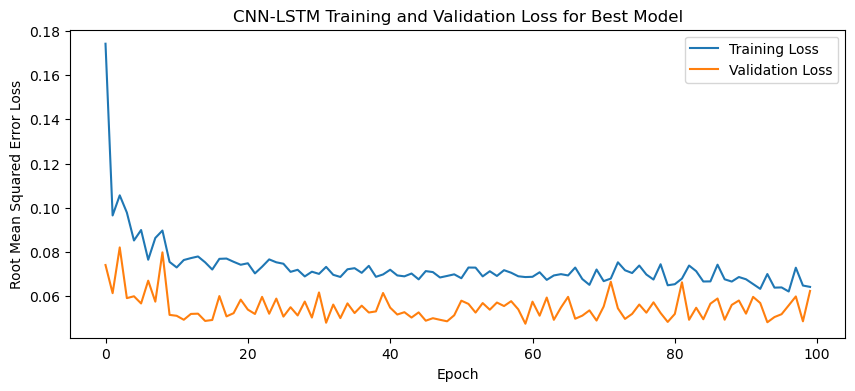

1/1 - 4s - loss: 0.0805 - 4s/epoch - 4s/step
Test Loss: 0.08049114048480988
Fold 2:
Epoch 1/100
19/19 [==============================] - 14s 305ms/step - loss: 0.1816 - val_loss: 0.0797
Epoch 2/100
19/19 [==============================] - 3s 172ms/step - loss: 0.0906 - val_loss: 0.0739
Epoch 3/100
19/19 [==============================] - 3s 179ms/step - loss: 0.0855 - val_loss: 0.0616
Epoch 4/100
19/19 [==============================] - 3s 173ms/step - loss: 0.0907 - val_loss: 0.1102
Epoch 5/100
19/19 [==============================] - 3s 153ms/step - loss: 0.0827 - val_loss: 0.0698
Epoch 6/100
19/19 [==============================] - 3s 161ms/step - loss: 0.0773 - val_loss: 0.0692
Epoch 7/100
19/19 [==============================] - 3s 156ms/step - loss: 0.0743 - val_loss: 0.0587
Epoch 8/100
19/19 [==============================] - 3s 179ms/step - loss: 0.0728 - val_loss: 0.0660
Epoch 9/100
19/19 [==============================] - 5s 273ms/step - loss: 0.0714 - val_loss: 0.0712
Epoch 

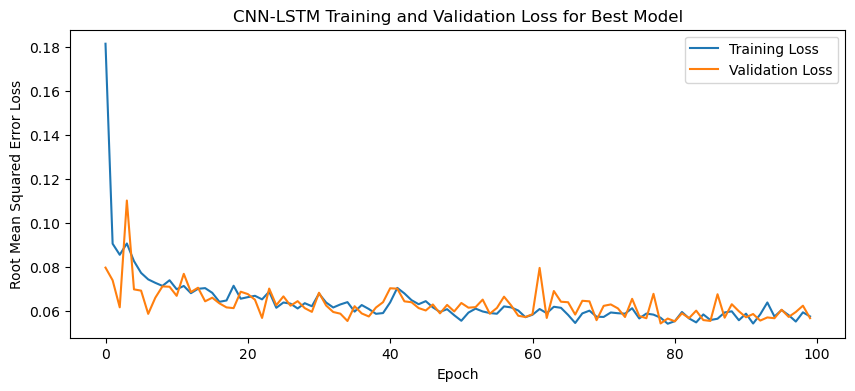

1/1 - 3s - loss: 0.0889 - 3s/epoch - 3s/step
Test Loss: 0.08889754861593246
Fold 3:
Epoch 1/100
19/19 [==============================] - 14s 287ms/step - loss: 0.1609 - val_loss: 0.0978
Epoch 2/100
19/19 [==============================] - 4s 193ms/step - loss: 0.1145 - val_loss: 0.1101
Epoch 3/100
19/19 [==============================] - 3s 162ms/step - loss: 0.1027 - val_loss: 0.0938
Epoch 4/100
19/19 [==============================] - 3s 167ms/step - loss: 0.0918 - val_loss: 0.0602
Epoch 5/100
19/19 [==============================] - 3s 156ms/step - loss: 0.0767 - val_loss: 0.0847
Epoch 6/100
19/19 [==============================] - 3s 140ms/step - loss: 0.0937 - val_loss: 0.1143
Epoch 7/100
19/19 [==============================] - 2s 122ms/step - loss: 0.0904 - val_loss: 0.0654
Epoch 8/100
19/19 [==============================] - 2s 130ms/step - loss: 0.0699 - val_loss: 0.0861
Epoch 9/100
19/19 [==============================] - 2s 112ms/step - loss: 0.0746 - val_loss: 0.0854
Epoch 

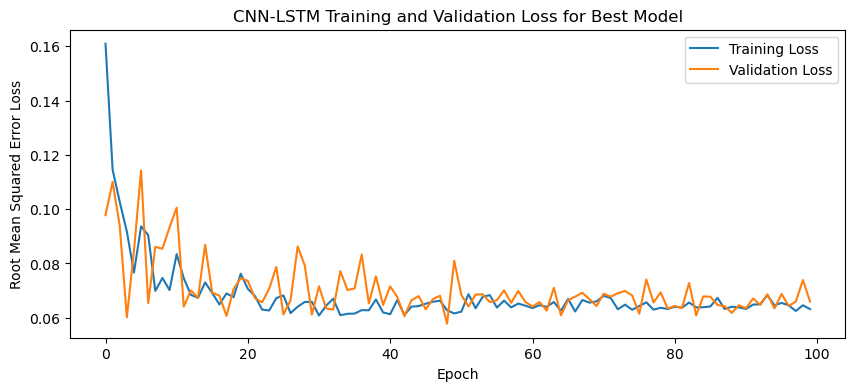

1/1 - 3s - loss: 0.0791 - 3s/epoch - 3s/step
Test Loss: 0.07908525317907333
Fold 4:
Epoch 1/100
20/20 [==============================] - 22s 432ms/step - loss: 0.2355 - val_loss: 0.1107
Epoch 2/100
20/20 [==============================] - 4s 179ms/step - loss: 0.1308 - val_loss: 0.0955
Epoch 3/100
20/20 [==============================] - 4s 220ms/step - loss: 0.1219 - val_loss: 0.1161
Epoch 4/100
20/20 [==============================] - 4s 229ms/step - loss: 0.1291 - val_loss: 0.0881
Epoch 5/100
20/20 [==============================] - 4s 199ms/step - loss: 0.1200 - val_loss: 0.0730
Epoch 6/100
20/20 [==============================] - 4s 173ms/step - loss: 0.1158 - val_loss: 0.0692
Epoch 7/100
20/20 [==============================] - 4s 196ms/step - loss: 0.1019 - val_loss: 0.0973
Epoch 8/100
20/20 [==============================] - 4s 211ms/step - loss: 0.1106 - val_loss: 0.1332
Epoch 9/100
20/20 [==============================] - 5s 233ms/step - loss: 0.1269 - val_loss: 0.1033
Epoch 

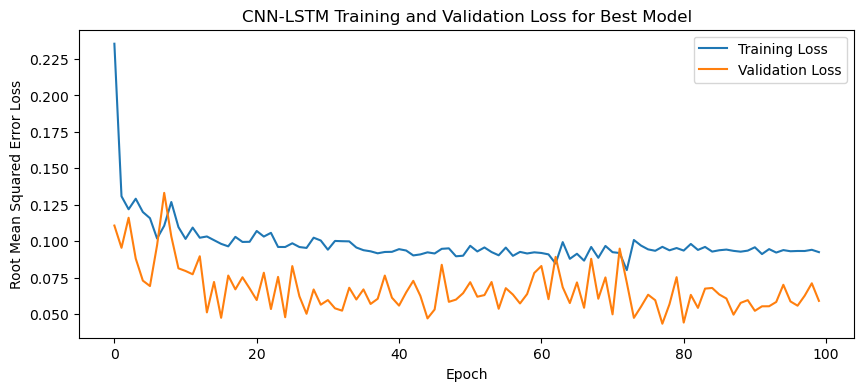

1/1 - 4s - loss: 0.0884 - 4s/epoch - 4s/step
Test Loss: 0.08839826285839081
Fold 5:
Epoch 1/100
19/19 [==============================] - 22s 343ms/step - loss: 0.1711 - val_loss: 0.1027
Epoch 2/100
19/19 [==============================] - 2s 134ms/step - loss: 0.0985 - val_loss: 0.0879
Epoch 3/100
19/19 [==============================] - 4s 206ms/step - loss: 0.0852 - val_loss: 0.0825
Epoch 4/100
19/19 [==============================] - 6s 295ms/step - loss: 0.0843 - val_loss: 0.0838
Epoch 5/100
19/19 [==============================] - 4s 236ms/step - loss: 0.0787 - val_loss: 0.0986
Epoch 6/100
19/19 [==============================] - 3s 140ms/step - loss: 0.0972 - val_loss: 0.1178
Epoch 7/100
19/19 [==============================] - 1s 76ms/step - loss: 0.0851 - val_loss: 0.0852
Epoch 8/100
19/19 [==============================] - 2s 123ms/step - loss: 0.0694 - val_loss: 0.0917
Epoch 9/100
19/19 [==============================] - 3s 181ms/step - loss: 0.0734 - val_loss: 0.0801
Epoch 1

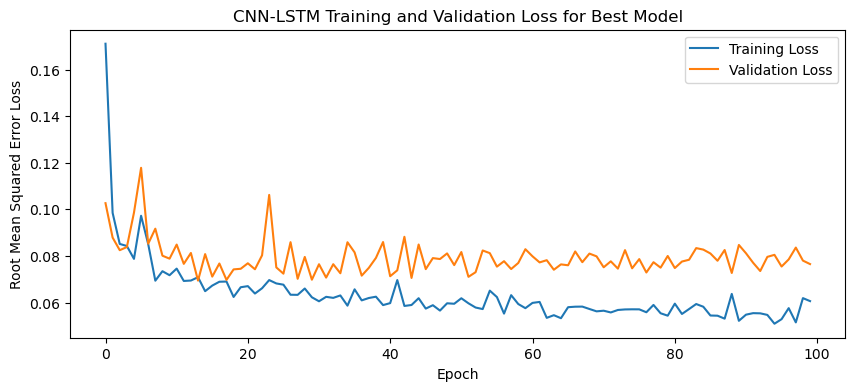

1/1 - 3s - loss: 0.0708 - 3s/epoch - 3s/step
Test Loss: 0.0707547664642334


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

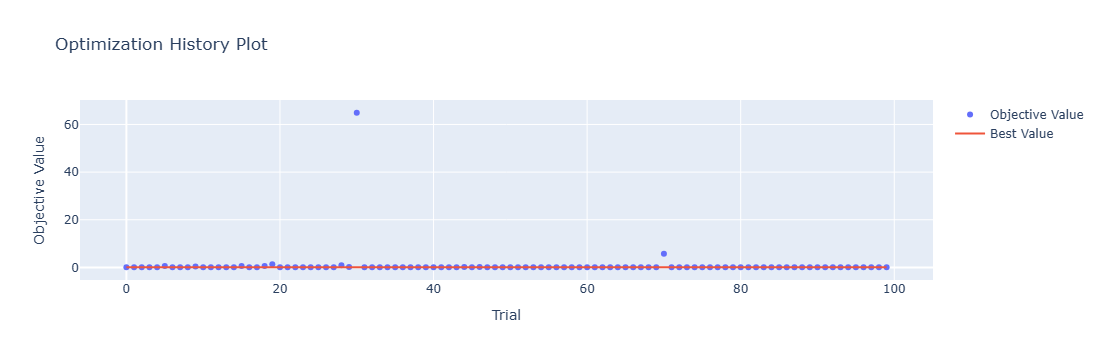

In [4]:
optuna.visualization.plot_optimization_history(study)

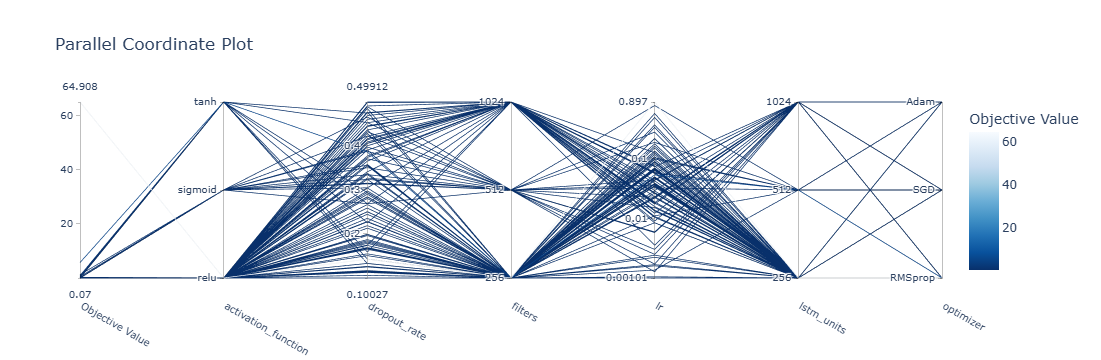

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

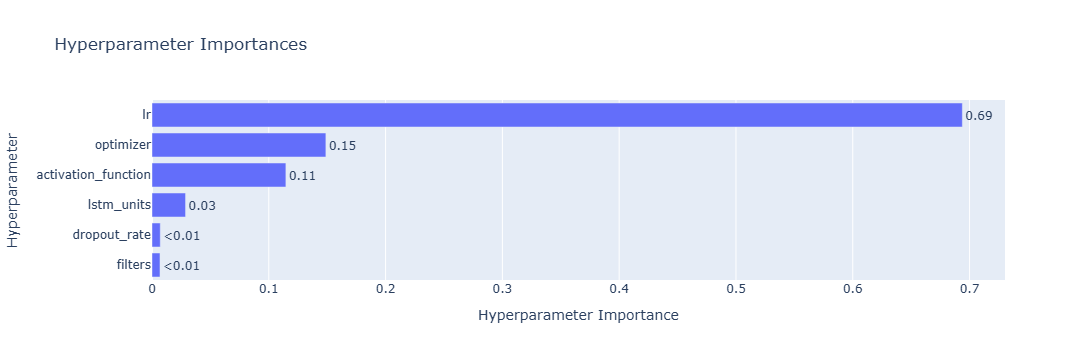

In [6]:
optuna.visualization.plot_param_importances(study)

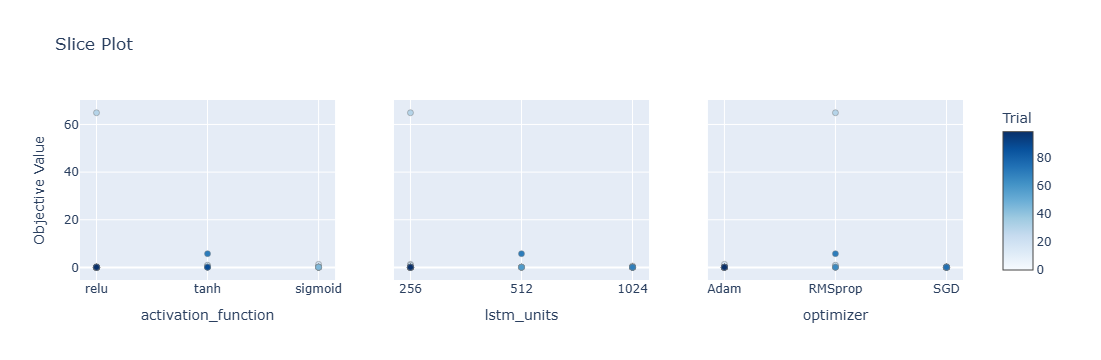

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

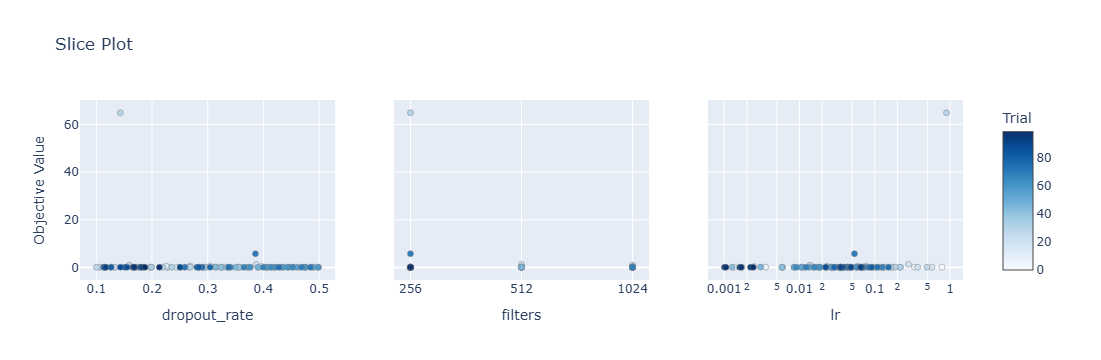

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate', 'filters'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 16s 309ms/step - loss: 0.2108 - accuracy: 0.3158 - mae: 0.1897 - rmse: 0.2108 - mape: 47.5038 - pearson: 0.2407 - val_loss: 0.0908 - val_accuracy: 0.3333 - val_mae: 0.0755 - val_rmse: 0.0908 - val_mape: 17.7565 - val_pearson: 0.0297
Epoch 2/100
19/19 [==============================] - 2s 110ms/step - loss: 0.1086 - accuracy: 0.2105 - mae: 0.0917 - rmse: 0.1086 - mape: 23.1974 - pearson: 0.2890 - val_loss: 0.0664 - val_accuracy: 0.6667 - val_mae: 0.0567 - val_rmse: 0.0664 - val_mape: 14.0028 - val_pearson: 0.4242
Epoch 3/100
19/19 [==============================] - 2s 102ms/step - loss: 0.0973 - accura

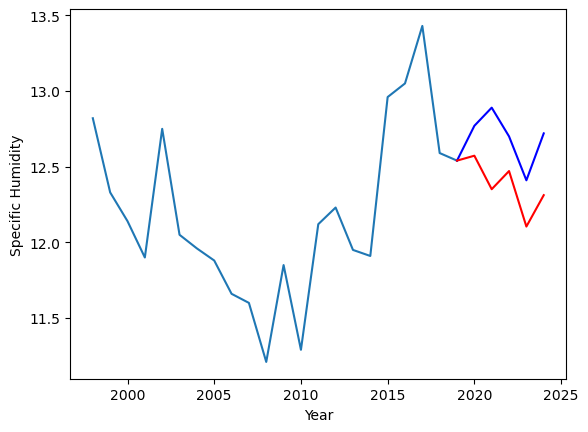

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.88		9.84		-0.04
10.09		9.59		-0.50
9.65		9.70		0.05
9.13		9.33		0.20
9.32		9.54		0.22


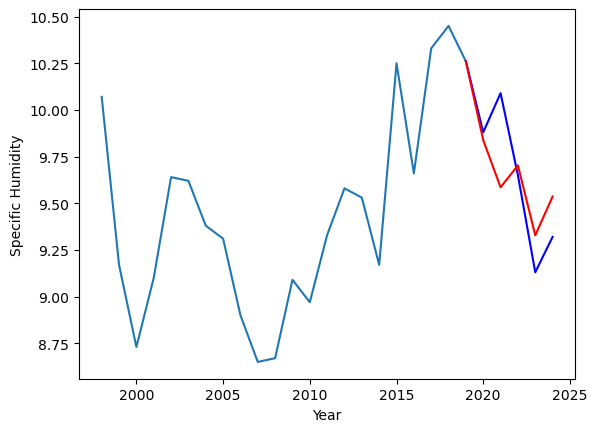

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.77  12.572495
1                1    9.88   9.838123


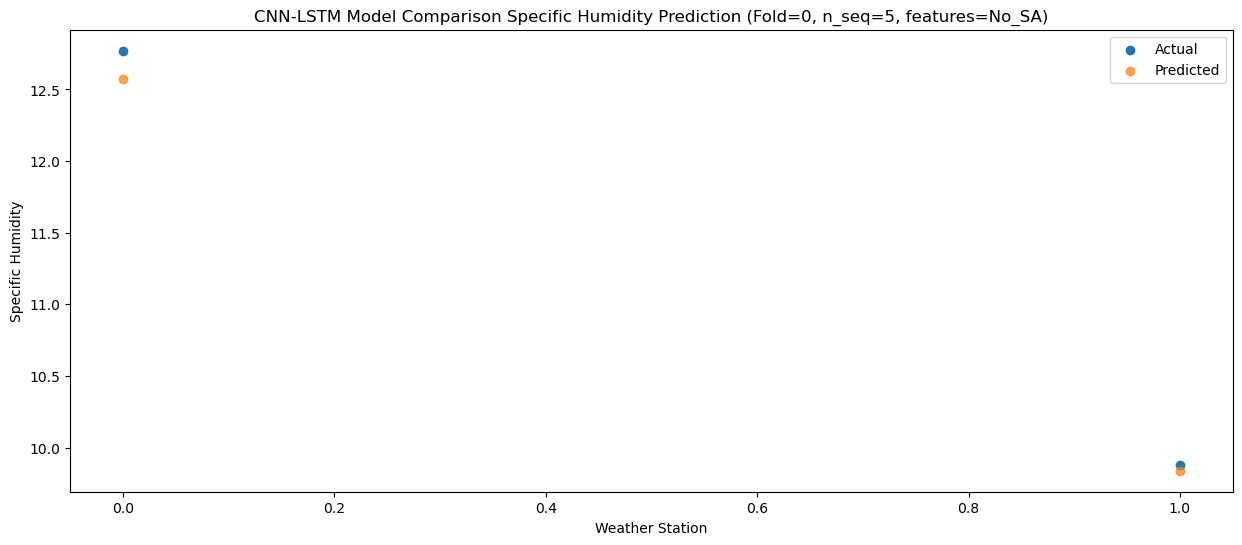

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.89  12.351148
1                1   10.09   9.585354


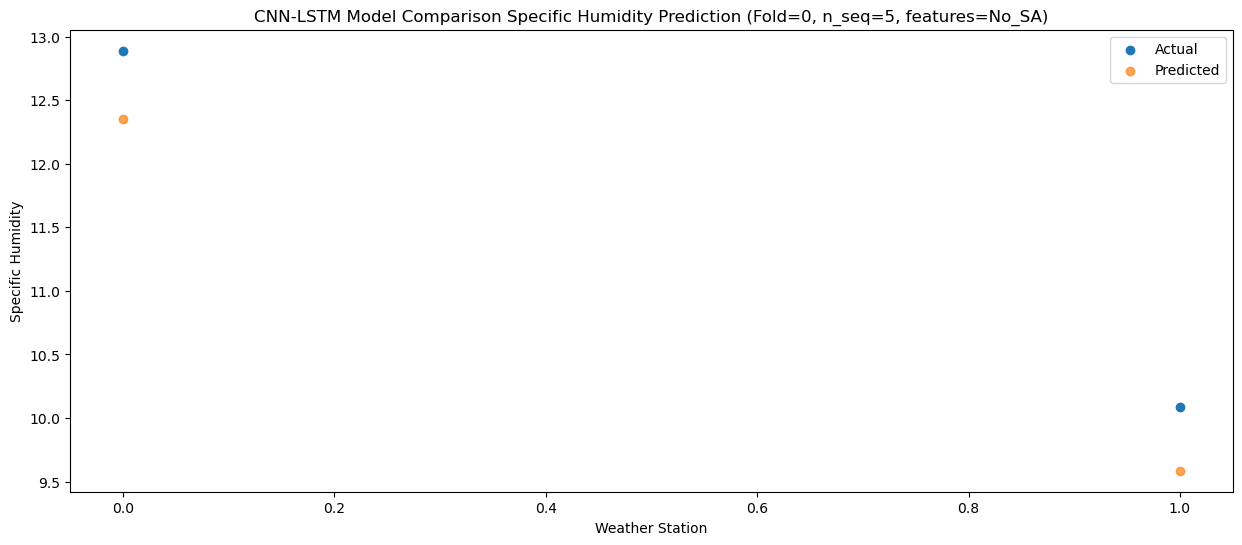

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   12.70  12.471154
1                1    9.65   9.702734


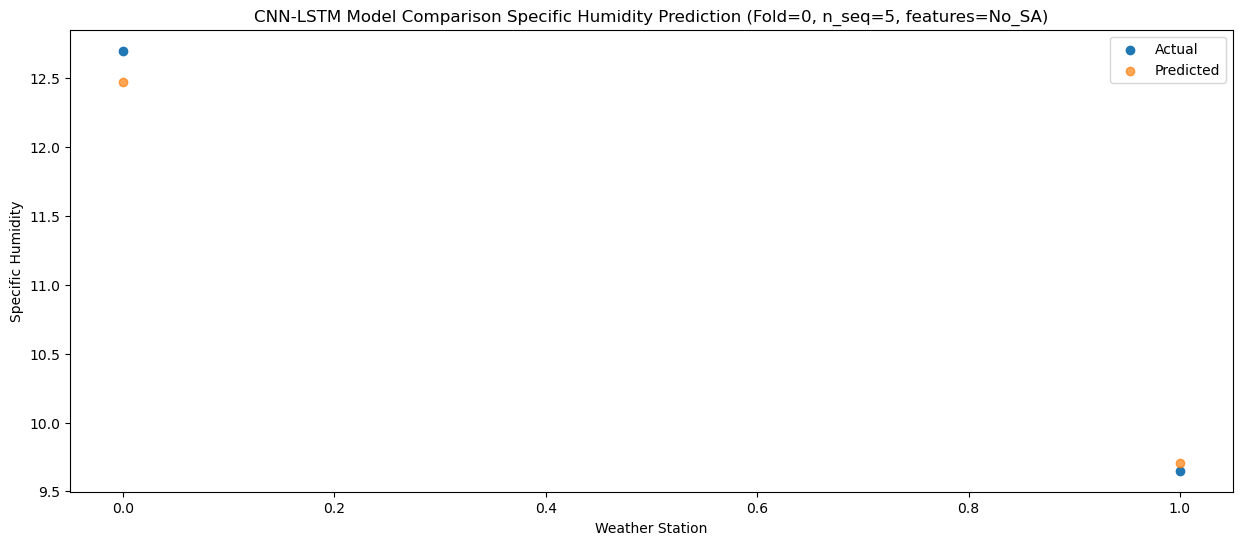

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.41  12.104361
1                1    9.13   9.328263


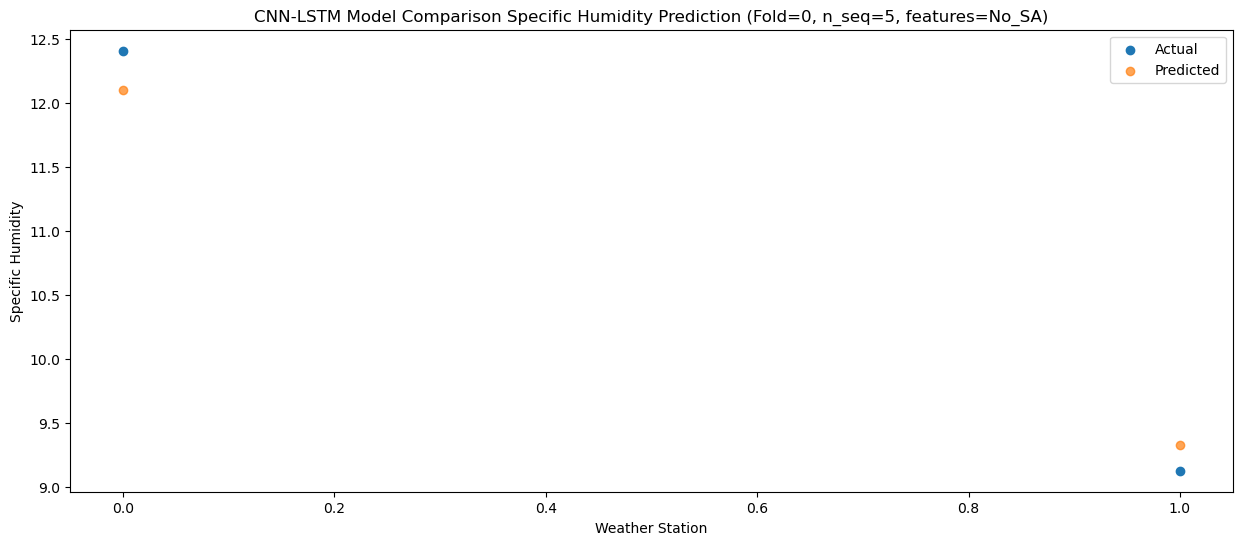

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   12.72  12.311890
1                1    9.32   9.536202


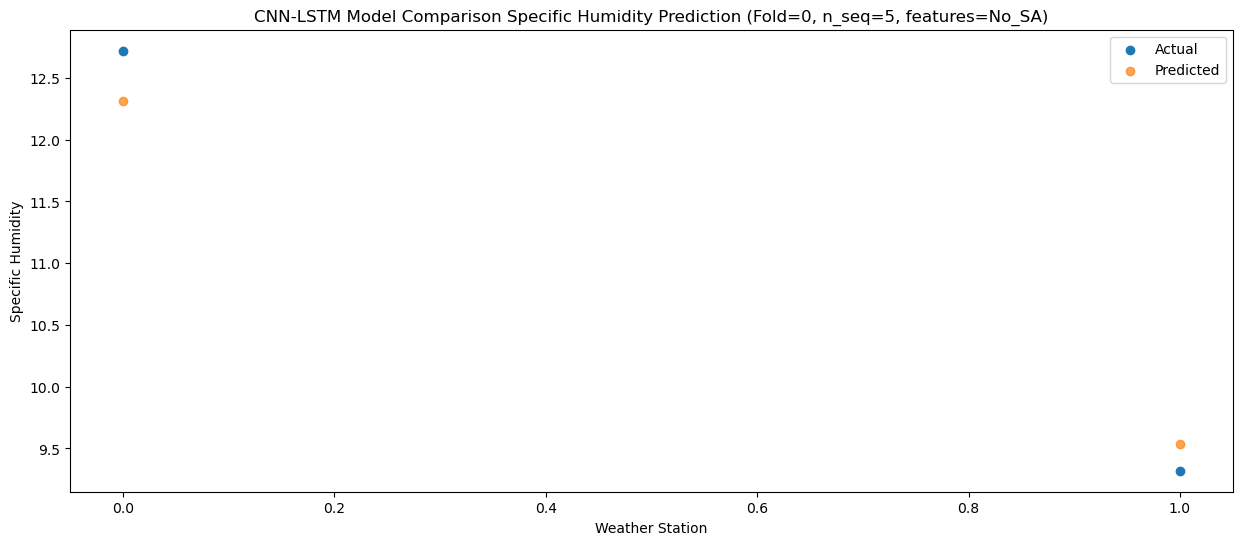

f, t:
[[12.77  9.88]
 [12.89 10.09]
 [12.7   9.65]
 [12.41  9.13]
 [12.72  9.32]]
[[12.57249456  9.83812331]
 [12.35114837  9.58535369]
 [12.47115422  9.70273361]
 [12.1043613   9.32826269]
 [12.31188972  9.53620216]]
Year at t+1:
t+1 SKRMSE: 0.142762
t+1 KRMSE: 0.142762
t+1 MAE: 0.119691
t+1 SKMAPE: 0.009852
t+1 R2_SCORE: 0.990239
t+1 KMAPE: 0.009852
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.325000
Year at t+2:
t+2 SKRMSE: 0.522029
t+2 KRMSE: 0.522029
t+2 MAE: 0.521749
t+2 SKMAPE: 0.045909
t+2 R2_SCORE: 0.860962
t+2 KMAPE: 0.045909
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 11.490000
Year at t+3:
t+3 SKRMSE: 0.166059
t+3 KRMSE: 0.166059
t+3 MAE: 0.140790
t+3 SKMAPE: 0.011742
t+3 R2_SCORE: 0.988143
t+3 KMAPE: 0.011742
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 11.175000
Year at t+4:
t+4 SKRMSE: 0.257607
t+4 KRMSE: 0.257607
t+4 MAE: 0.251951
t+4 SKMAPE: 0.023172
t+4 R2_SCORE: 0.975327
t+4 KMAPE: 0.023172
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 10.770000
Year at t+5:
t+5 SKRMSE: 0.326

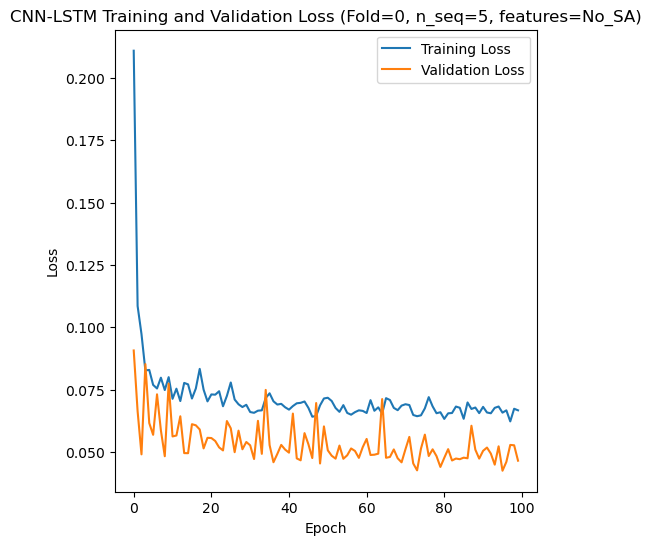

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 23s 299ms/step - loss: 0.1907 - accuracy: 0.2105 - mae: 0.1792 - rmse: 0.1907 - mape: 43.1421 - pearson: 0.2776 - val_loss: 0.1115 - val_accuracy: 0.3333 - val_mae: 0.1024 - val_rmse: 0.1115 - val_mape: 26.8953 - val_pearson: 0.1038
Epoch 2/100
19/19 [==============================] - 2s 116ms/step - loss: 0.1008 - accuracy: 0.3158 - mae: 0.0867 - rmse: 0.1008 - mape: 20.6164 - pearson: 0.3797 - val_loss: 0.1012 - val_accuracy: 0.3333 - val_mae: 0.0931 - val_rmse: 0.1012 - val_mape: 23.6612 - val_pearson: 0.1268
Epoch 3/100
19/19 [==============================] - 3s 143ms/step - loss: 0.0908 - accura

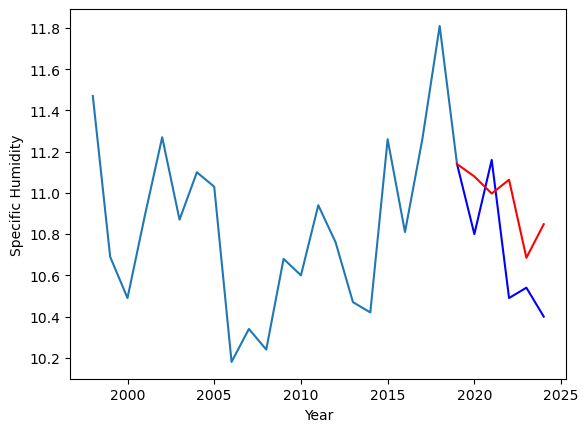

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.66		7.24		-0.42
6.92		7.16		0.24
7.36		7.22		-0.14
6.79		6.85		0.06
6.94		7.01		0.07


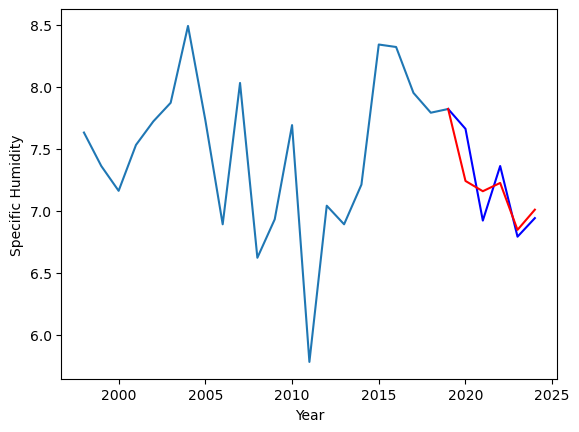

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   10.80  11.079703
1                1    7.66   7.239583


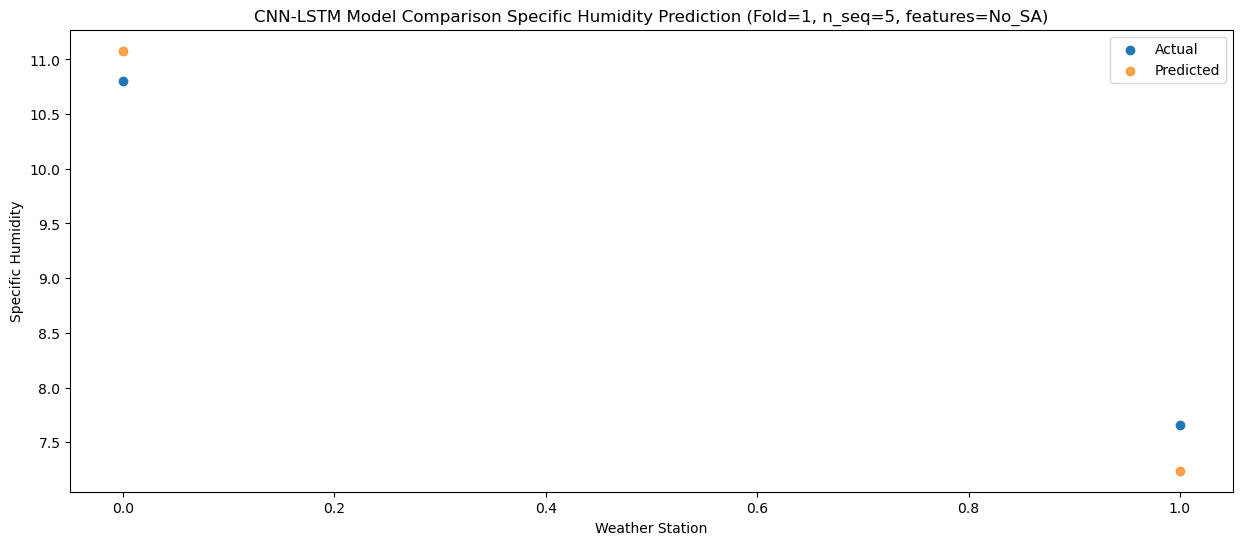

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   11.16  10.996934
1                1    6.92   7.156804


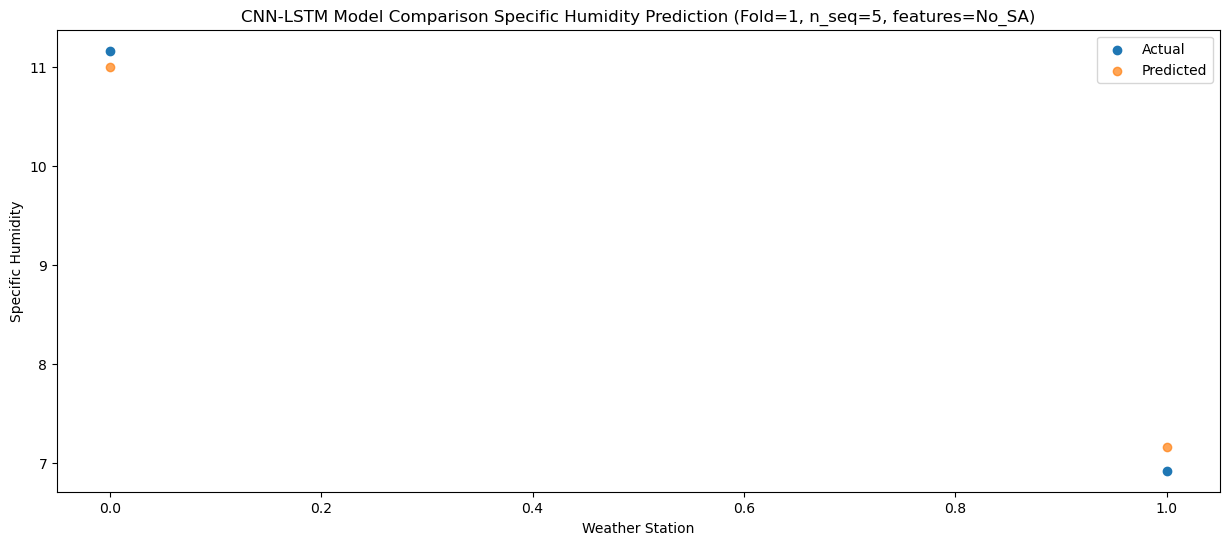

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   10.49  11.063734
1                1    7.36   7.223675


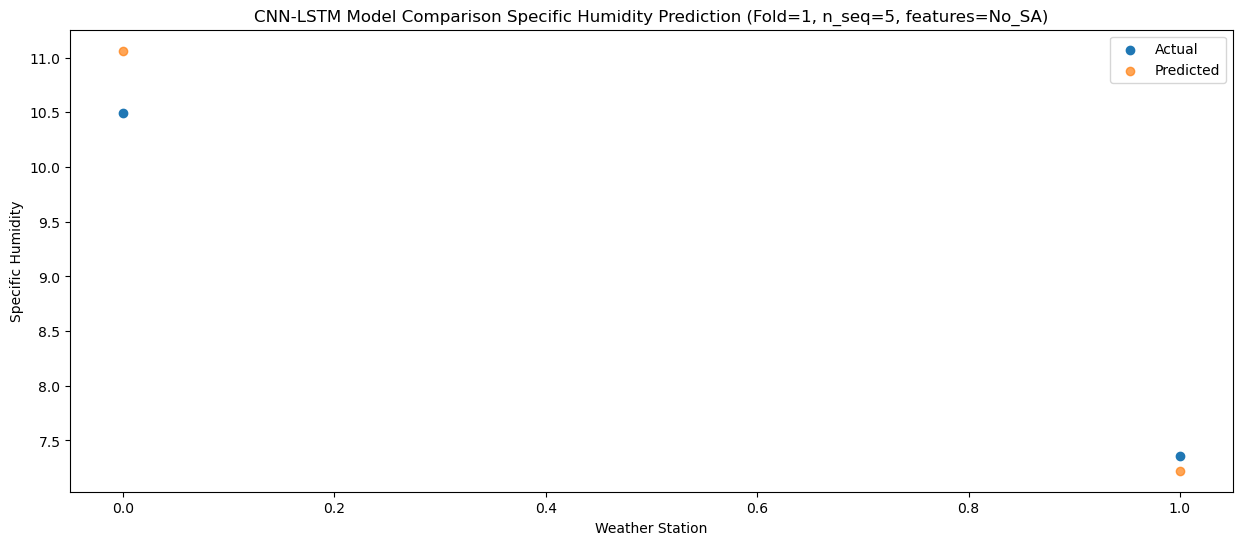

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.54  10.685220
1                1    6.79   6.845142


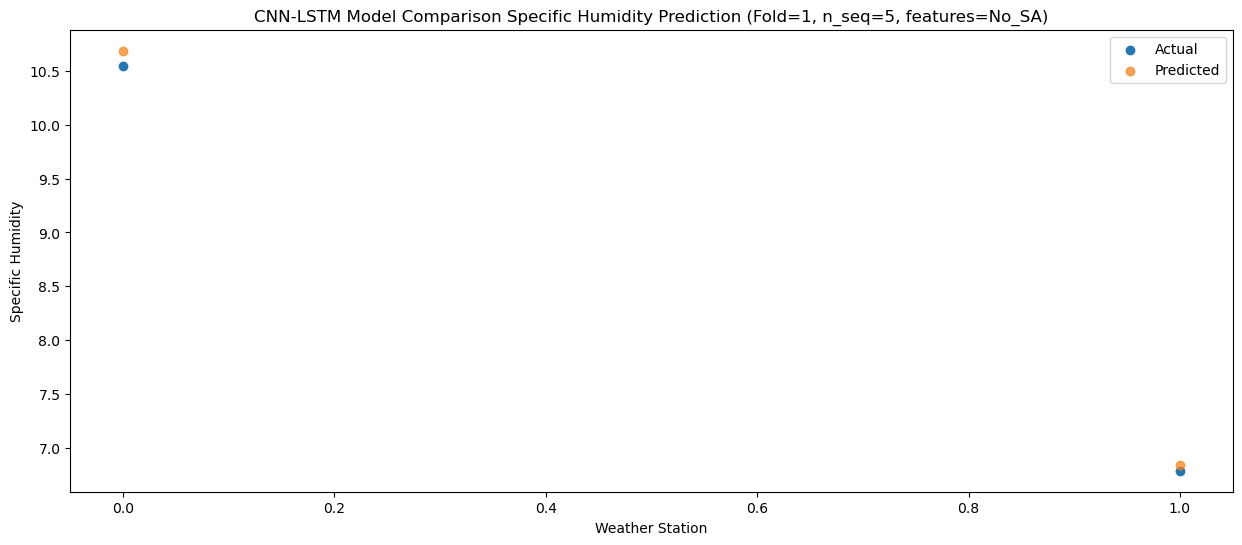

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   10.40  10.847941
1                1    6.94   7.007981


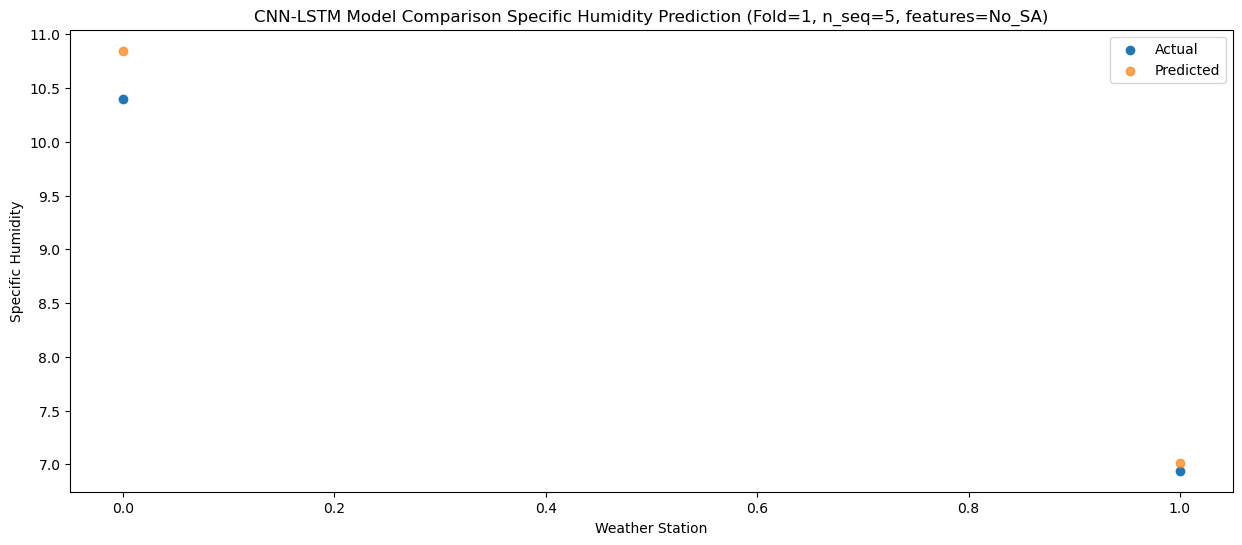

f, t:
[[10.8   7.66]
 [11.16  6.92]
 [10.49  7.36]
 [10.54  6.79]
 [10.4   6.94]]
[[11.07970277  7.23958323]
 [10.9969342   7.15680399]
 [11.06373431  7.22367468]
 [10.68521972  6.8451423 ]
 [10.84794104  7.00798072]]
Year at t+1:
t+1 SKRMSE: 0.357060
t+1 KRMSE: 0.357060
t+1 MAE: 0.350060
t+1 SKMAPE: 0.040392
t+1 R2_SCORE: 0.948277
t+1 KMAPE: 0.040392
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.230000
Year at t+2:
t+2 SKRMSE: 0.203306
t+2 KRMSE: 0.203306
t+2 MAE: 0.199935
t+2 SKMAPE: 0.024416
t+2 R2_SCORE: 0.990803
t+2 KMAPE: 0.024416
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.040000
Year at t+3:
t+3 SKRMSE: 0.416987
t+3 KRMSE: 0.416987
t+3 MAE: 0.355030
t+3 SKMAPE: 0.036608
t+3 R2_SCORE: 0.929007
t+3 KMAPE: 0.036608
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 8.925000
Year at t+4:
t+4 SKRMSE: 0.109840
t+4 KRMSE: 0.109840
t+4 MAE: 0.100181
t+4 SKMAPE: 0.010950
t+4 R2_SCORE: 0.996568
t+4 KMAPE: 0.010950
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.665000
Year at t+5:
t+5 SKRMSE: 0.320369


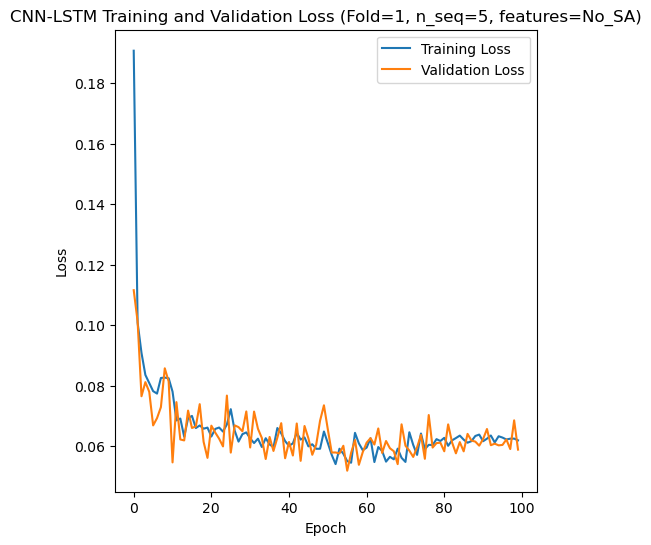

[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 30s 397ms/step - loss: 0.1895 - accuracy: 0.4737 - mae: 0.1706 - rmse: 0.1895 - mape: 40.4711 - pearson: 0.1484 - val_loss: 0.1023 - val_accuracy: 0.0000e+00 - val_mae: 0.0693 - val_rmse: 0.1023 - val_mape: 19.7853 - val_pearson: 0.1540
Epoch 2/100
19/19 [==============================] - 3s 147ms/step - loss: 0.1212 - accuracy: 0.2632 - mae: 0.1032 - rmse: 0.1212 - mape: 24.9578 - pearson: 0.1856 - val_loss: 0.1275 - val_accuracy: 0.6667 - val_mae: 0.1101 - val_rmse: 0.1275 - val_mape: 27.7167 - val_pearson: 0.1698
Epoch 3/100
19/19 [==============================] - 3s 150ms/step - loss: 0.0882 - ac

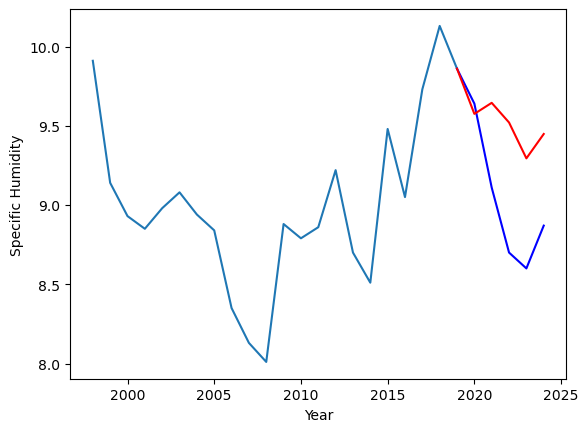

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.84		8.18		0.34
7.66		8.00		0.34
7.73		8.17		0.44
8.00		7.76		-0.24
8.01		8.06		0.05


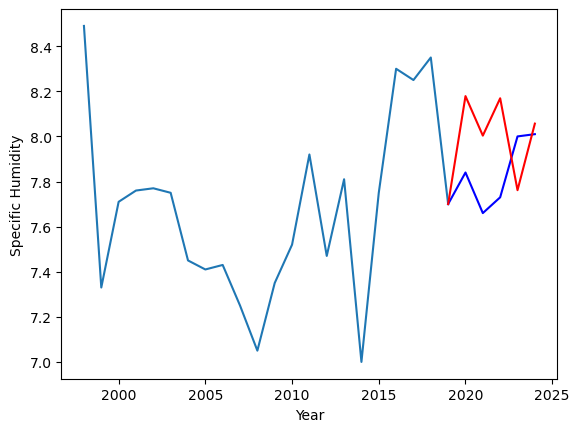

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.64   9.575114
1                1    7.84   8.178754


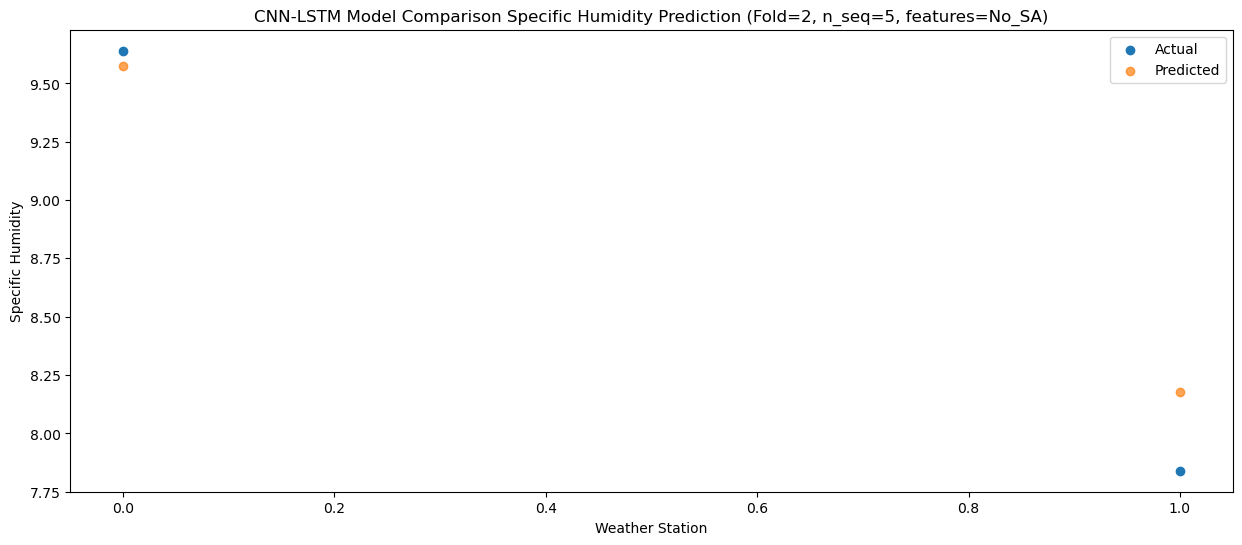

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    9.11   9.644682
1                1    7.66   8.003531


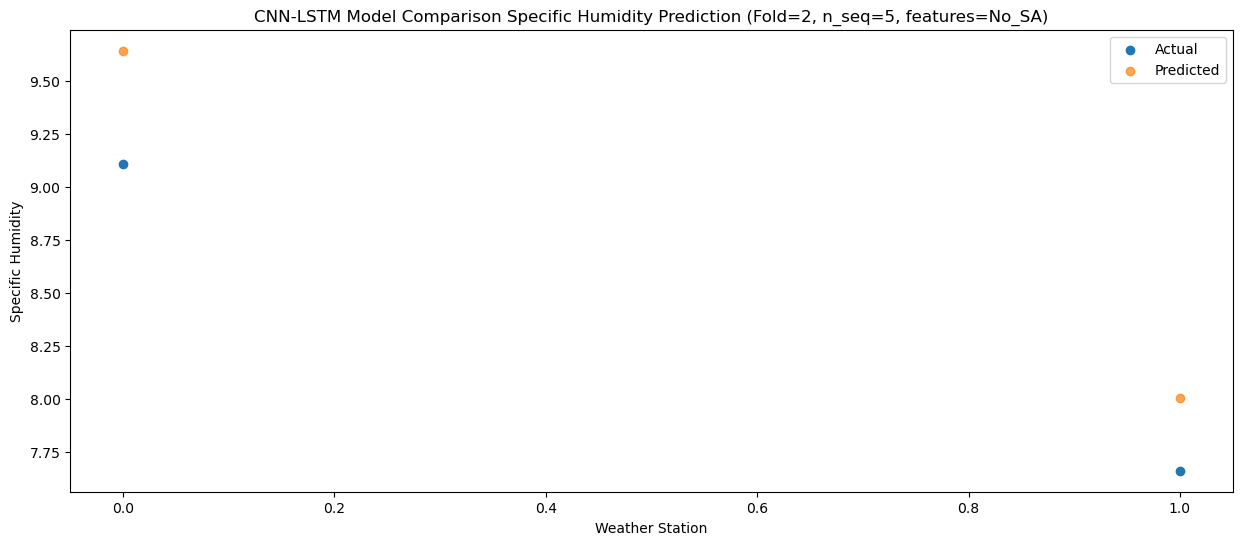

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    8.70   9.520595
1                1    7.73   8.169148


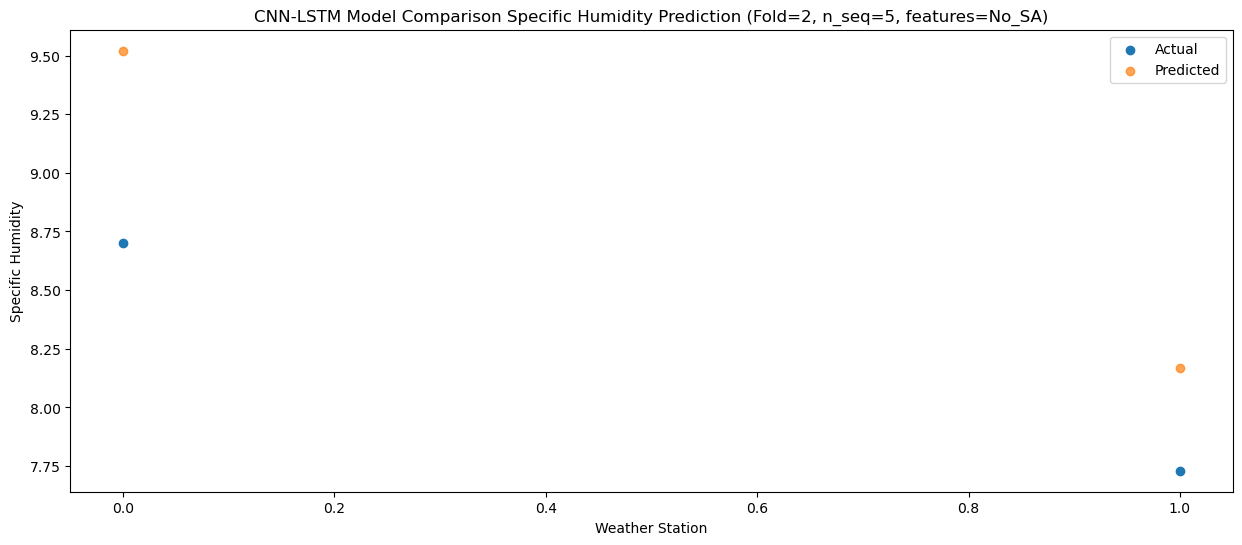

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0     8.6   9.294364
1                1     8.0   7.761592


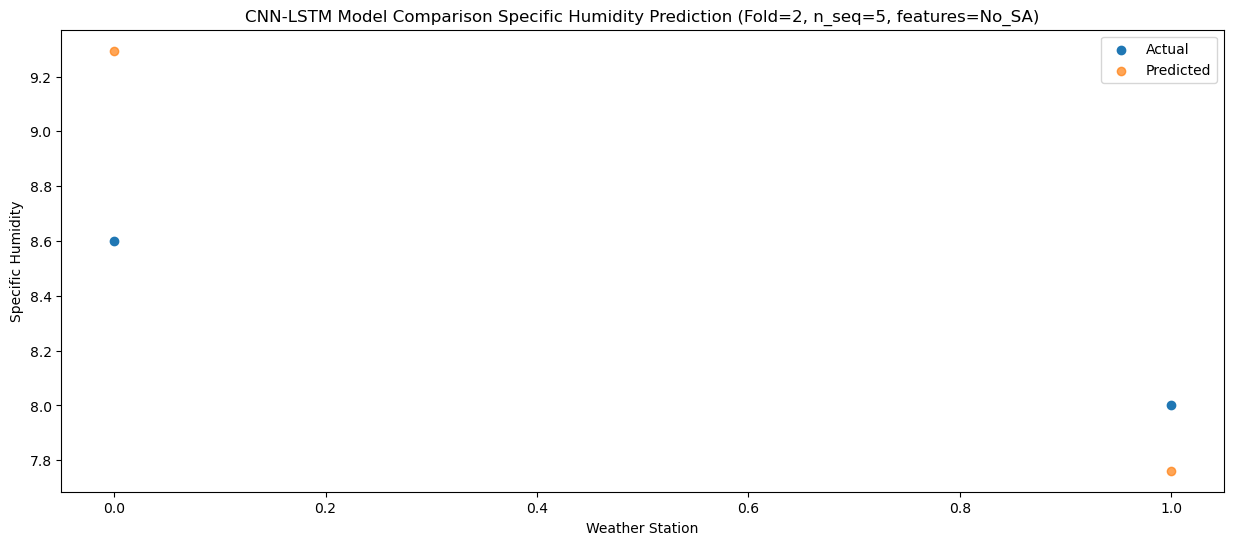

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    8.87   9.448193
1                1    8.01   8.056763


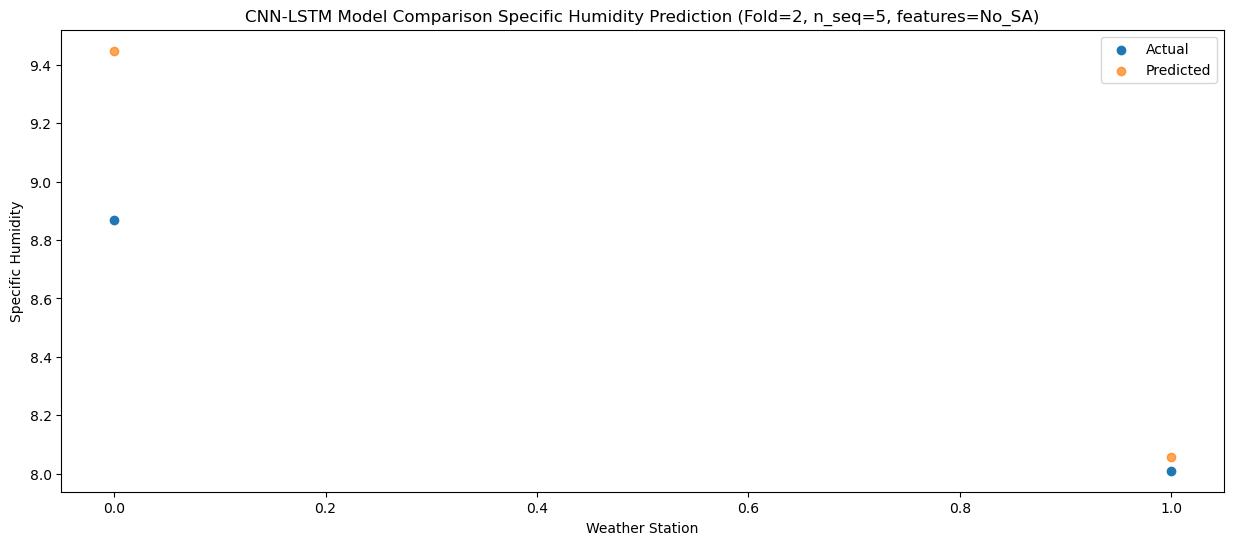

f, t:
[[9.64 7.84]
 [9.11 7.66]
 [8.7  7.73]
 [8.6  8.  ]
 [8.87 8.01]]
[[9.57511446 8.1787536 ]
 [9.64468244 8.00353084]
 [9.5205951  8.16914847]
 [9.29436385 7.76159184]
 [9.4481931  8.05676319]]
Year at t+1:
t+1 SKRMSE: 0.243889
t+1 KRMSE: 0.243889
t+1 MAE: 0.201820
t+1 SKMAPE: 0.024970
t+1 R2_SCORE: 0.926565
t+1 KMAPE: 0.024970
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 8.740000
Year at t+2:
t+2 SKRMSE: 0.449388
t+2 KRMSE: 0.449388
t+2 MAE: 0.439107
t+2 SKMAPE: 0.051770
t+2 R2_SCORE: 0.615792
t+2 KMAPE: 0.051770
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 8.385000
Year at t+3:
t+3 SKRMSE: 0.658114
t+3 KRMSE: 0.658114
t+3 MAE: 0.629872
t+3 SKMAPE: 0.075566
t+3 R2_SCORE: -0.841275
t+3 KMAPE: 0.075566
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 8.215000
Year at t+4:
t+4 SKRMSE: 0.519124
t+4 KRMSE: 0.519124
t+4 MAE: 0.466386
t+4 SKMAPE: 0.055271
t+4 R2_SCORE: -1.994331
t+4 KMAPE: 0.055271
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.300000
Year at t+5:
t+5 SKRMSE: 0.410179
t+5 KRMSE: 0.41017

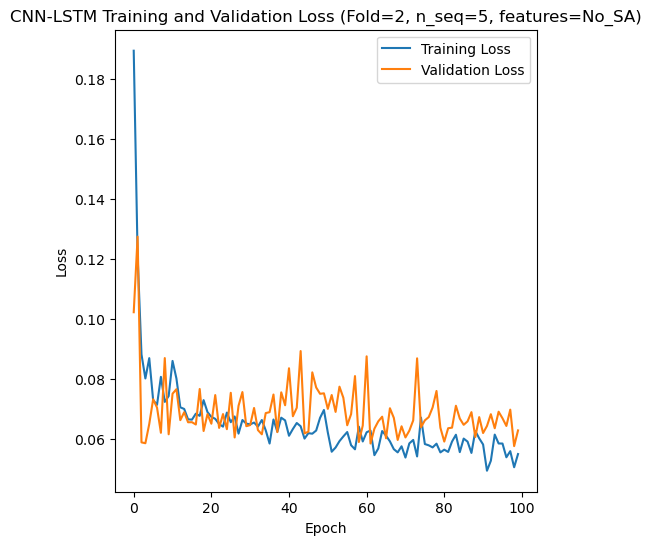

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 20s 363ms/step - loss: 0.2737 - accuracy: 0.2500 - mae: 0.2491 - rmse: 0.2737 - mape: 43.0436 - pearson: 0.3018 - val_loss: 0.1004 - val_accuracy: 0.0000e+00 - val_mae: 0.0722 - val_rmse: 0.1004 - val_mape: 11.4075 - val_pearson: 0.4695
Epoch 2/100
20/20 [==============================] - 3s 126ms/step - loss: 0.1437 - accuracy: 0.3000 - mae: 0.1218 - rmse: 0.1437 - mape: 21.9121 - pearson: 0.3535 - val_loss: 0.0546 - val_accuracy: 0.0000e+00 - val_mae: 0.0444 - val_rmse: 0.0546 - val_mape: 7.2320 - val_pearson: 0.8954
Epoch 3/100
20/20 [==============================] - 2s 78ms/step - loss: 0.1190 - accuracy: 0.3000 - mae: 0.0997 - rmse: 0.1190 - mape: 18.1

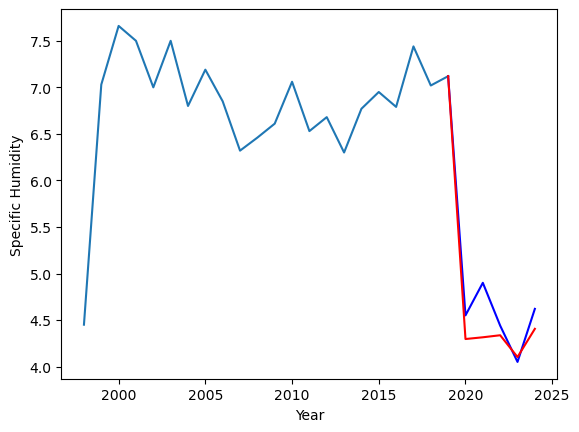

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.21		8.21		0.00
8.12		8.13		0.01
8.09		8.20		0.11
7.62		7.86		0.24
7.64		8.19		0.55


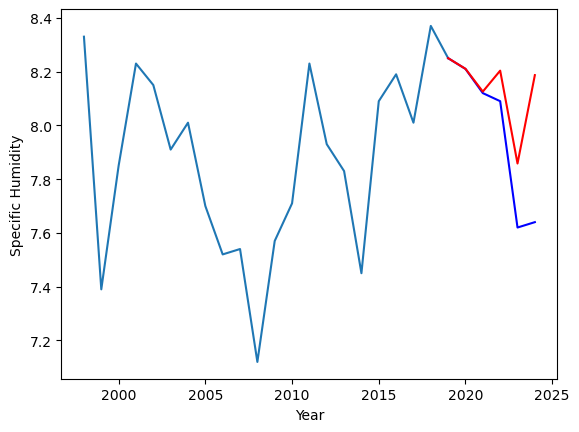

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    4.55   4.296090
1                1    8.21   8.210407


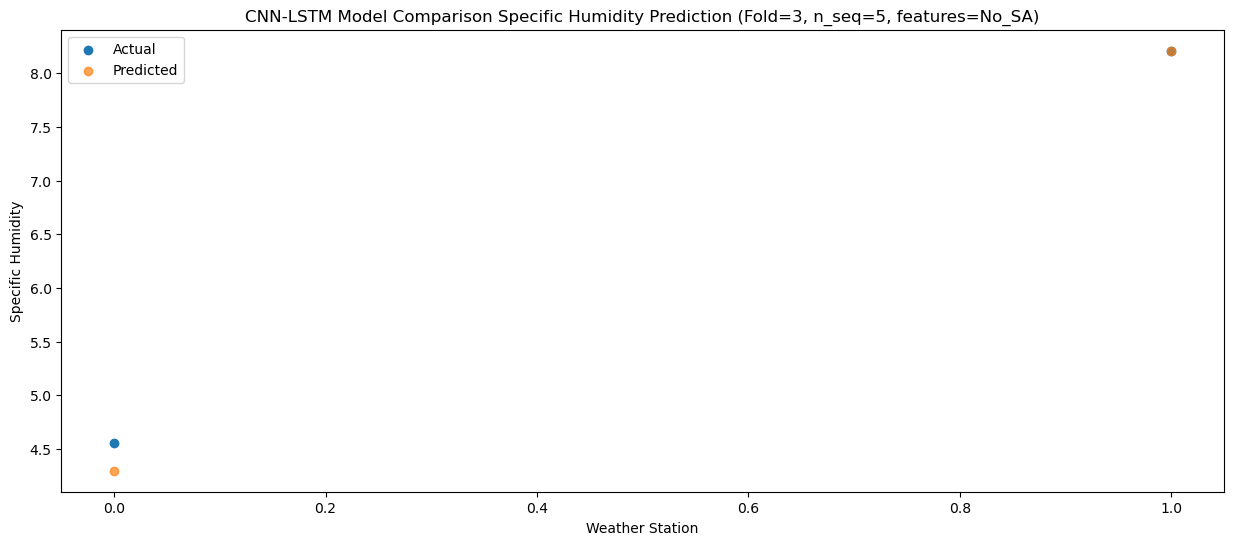

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    4.90   4.314719
1                1    8.12   8.125705


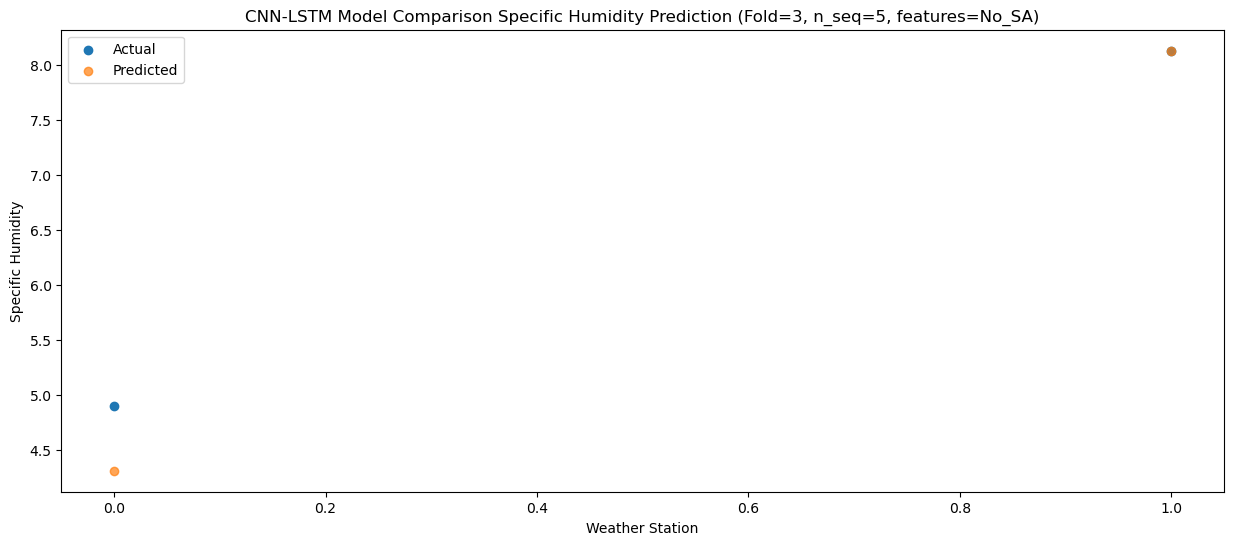

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    4.44   4.336591
1                1    8.09   8.203604


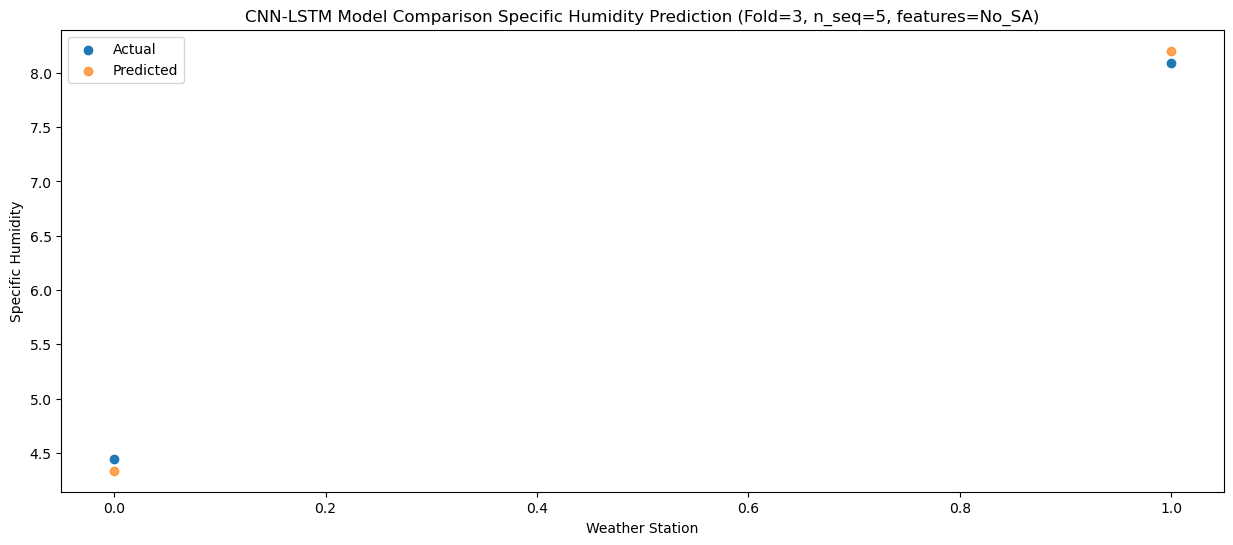

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0    4.05    4.10261
1                1    7.62    7.85810


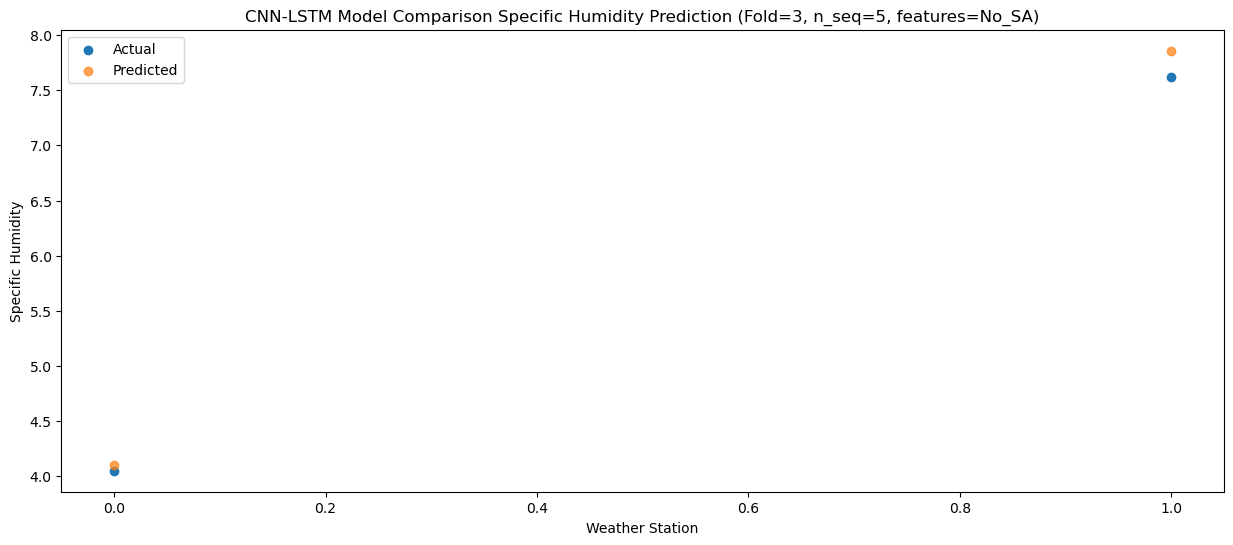

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    4.62   4.405424
1                1    7.64   8.186933


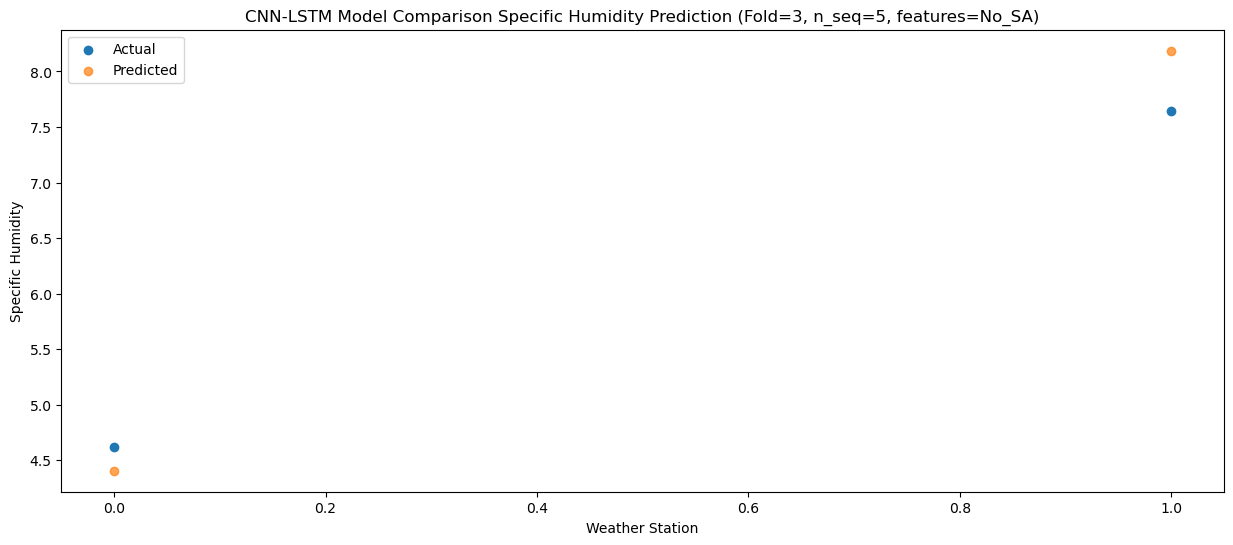

f, t:
[[4.55 8.21]
 [4.9  8.12]
 [4.44 8.09]
 [4.05 7.62]
 [4.62 7.64]]
[[4.29608981 8.21040724]
 [4.31471885 8.12570462]
 [4.33659146 8.20360352]
 [4.10260971 7.85810013]
 [4.40542368 8.18693293]]
Year at t+1:
t+1 SKRMSE: 0.179542
t+1 KRMSE: 0.179542
t+1 MAE: 0.127159
t+1 SKMAPE: 0.027927
t+1 R2_SCORE: 0.990374
t+1 KMAPE: 0.027927
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.380000
Year at t+2:
t+2 SKRMSE: 0.413876
t+2 KRMSE: 0.413876
t+2 MAE: 0.295493
t+2 SKMAPE: 0.060074
t+2 R2_SCORE: 0.933917
t+2 KMAPE: 0.060074
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 6.510000
Year at t+3:
t+3 SKRMSE: 0.108626
t+3 KRMSE: 0.108626
t+3 MAE: 0.108506
t+3 SKMAPE: 0.018666
t+3 R2_SCORE: 0.996457
t+3 KMAPE: 0.018666
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 6.265000
Year at t+4:
t+4 SKRMSE: 0.172423
t+4 KRMSE: 0.172423
t+4 MAE: 0.145355
t+4 SKMAPE: 0.022118
t+4 R2_SCORE: 0.990669
t+4 KMAPE: 0.022118
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 5.835000
Year at t+5:
t+5 SKRMSE: 0.415439
t+5 KRMSE: 0.415439


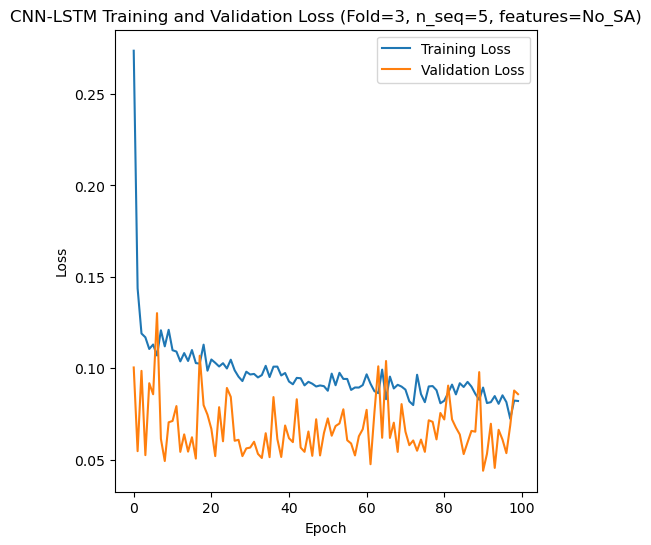

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 23s 363ms/step - loss: 0.1906 - accuracy: 0.2105 - mae: 0.1712 - rmse: 0.1906 - mape: 40.2228 - pearson: 0.2021 - val_loss: 0.1067 - val_accuracy: 0.0000e+00 - val_mae: 0.0918 - val_rmse: 0.1067 - val_mape: 20.8879 - val_pearson: 0.2518
Epoch 2/100
19/19 [==============================] - 1s 50ms/step - loss: 0.0874 - accuracy: 0.1053 - mae: 0.0721 - rmse: 0.0874 - mape: 17.9831 - pearson: 0.3885 - val_loss: 0.1150 - val_accuracy: 0.0000e+00 - val_mae: 0.0982 - val_rmse: 0.1150 - val_mape: 25.0171 - val_pearson: 0.4134
Epoch 3/100
19/19 [==============================] - 1s 48ms/step - loss: 0.0973 - a

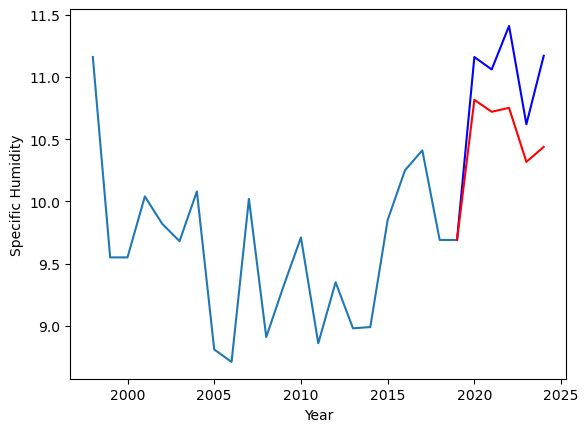

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.79		7.99		0.20
7.52		7.89		0.37
7.85		7.92		0.07
7.25		7.49		0.24
7.48		7.61		0.13


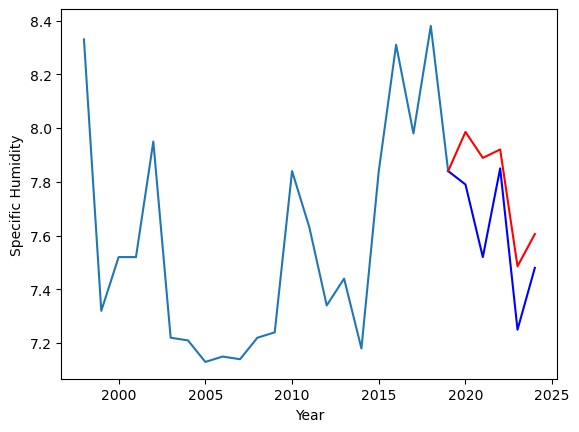

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.16  10.815956
1                1    7.79   7.985632


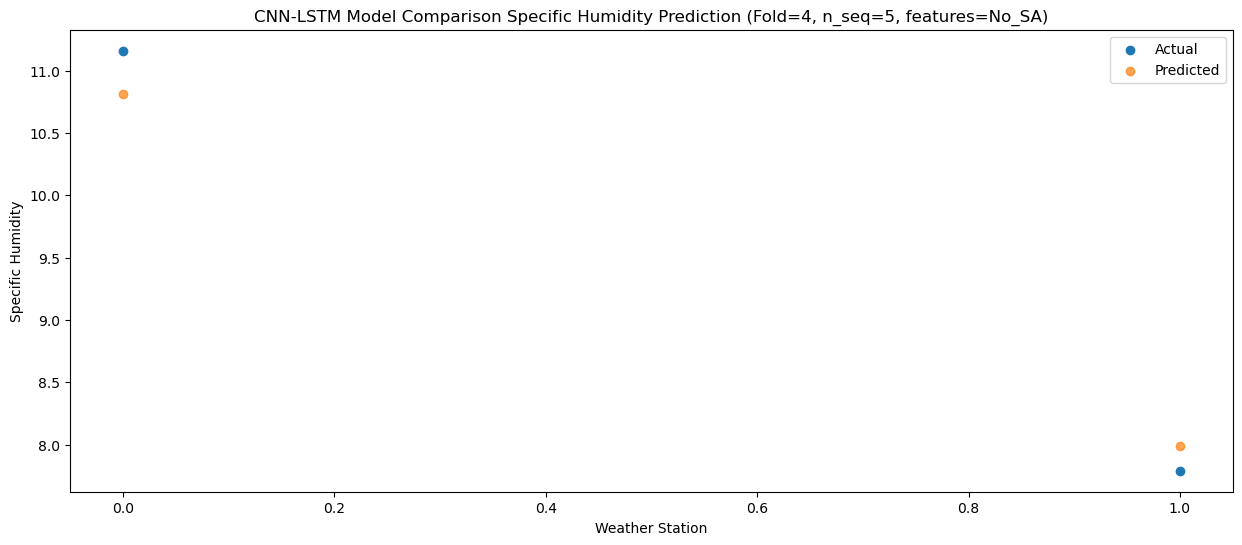

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   11.06  10.719922
1                1    7.52   7.889036


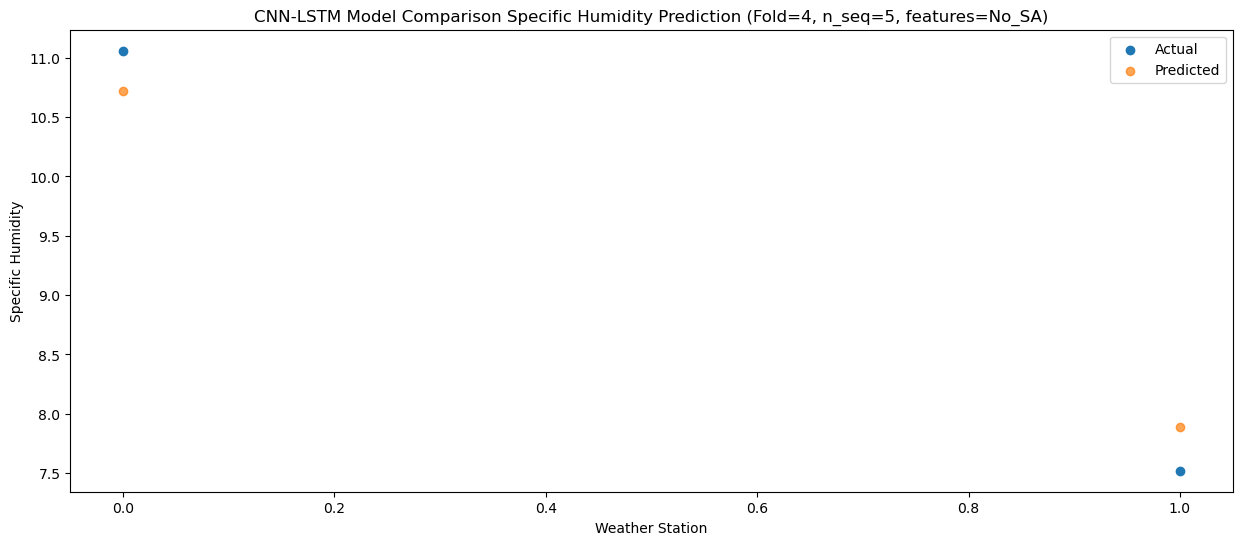

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   11.41  10.751824
1                1    7.85   7.920335


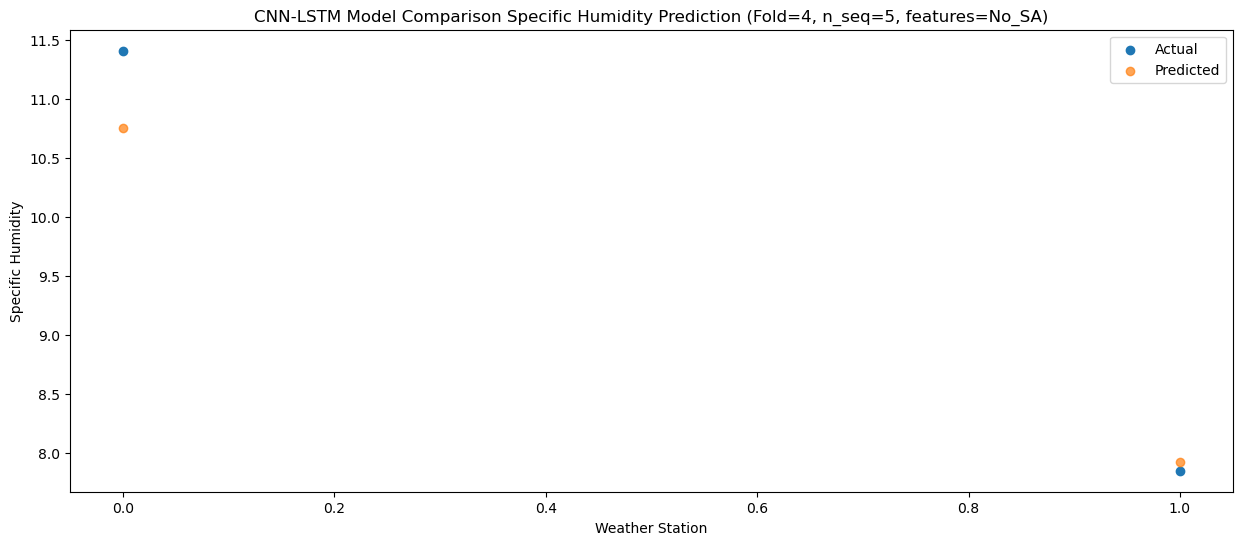

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.62  10.317422
1                1    7.25   7.485690


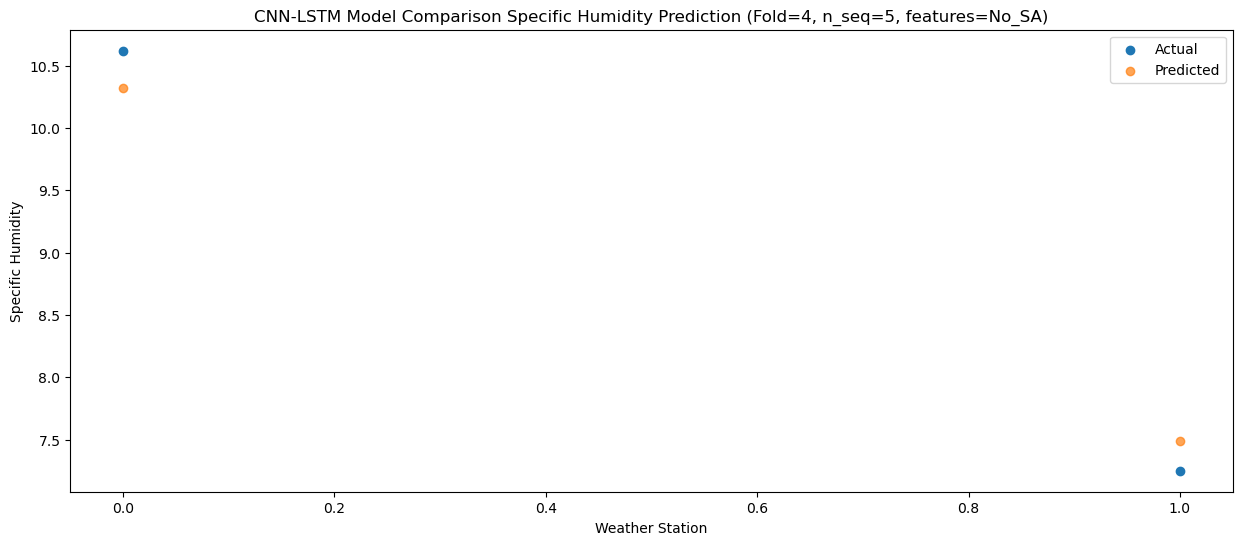

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.17  10.438051
1                1    7.48   7.605797


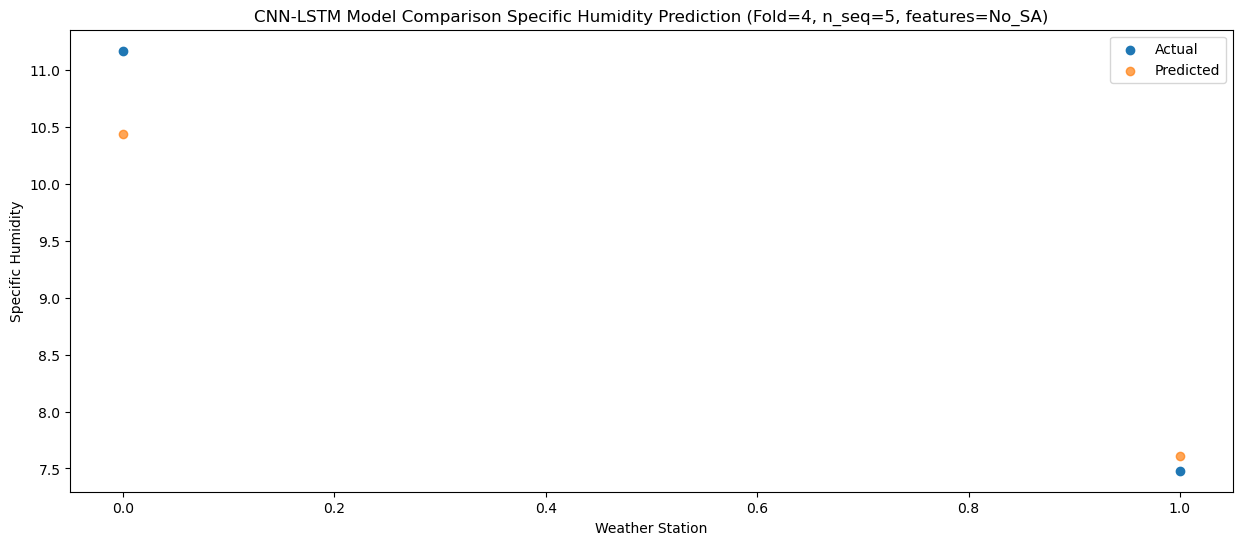

f, t:
[[11.16  7.79]
 [11.06  7.52]
 [11.41  7.85]
 [10.62  7.25]
 [11.17  7.48]]
[[10.81595621  7.98563214]
 [10.71992231  7.88903561]
 [10.75182388  7.92033529]
 [10.31742225  7.48568988]
 [10.43805137  7.60579727]]
Year at t+1:
t+1 SKRMSE: 0.279855
t+1 KRMSE: 0.279855
t+1 MAE: 0.269838
t+1 SKMAPE: 0.027971
t+1 R2_SCORE: 0.972415
t+1 KMAPE: 0.027971
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.475000
Year at t+2:
t+2 SKRMSE: 0.354852
t+2 KRMSE: 0.354852
t+2 MAE: 0.354557
t+2 SKMAPE: 0.039911
t+2 R2_SCORE: 0.959807
t+2 KMAPE: 0.039911
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.290000
Year at t+3:
t+3 SKRMSE: 0.468051
t+3 KRMSE: 0.468051
t+3 MAE: 0.364256
t+3 SKMAPE: 0.033322
t+3 R2_SCORE: 0.930857
t+3 KMAPE: 0.033322
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 9.630000
Year at t+4:
t+4 SKRMSE: 0.271204
t+4 KRMSE: 0.271204
t+4 MAE: 0.269134
t+4 SKMAPE: 0.030500
t+4 R2_SCORE: 0.974095
t+4 KMAPE: 0.030500
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.935000
Year at t+5:
t+5 SKRMSE: 0.525154


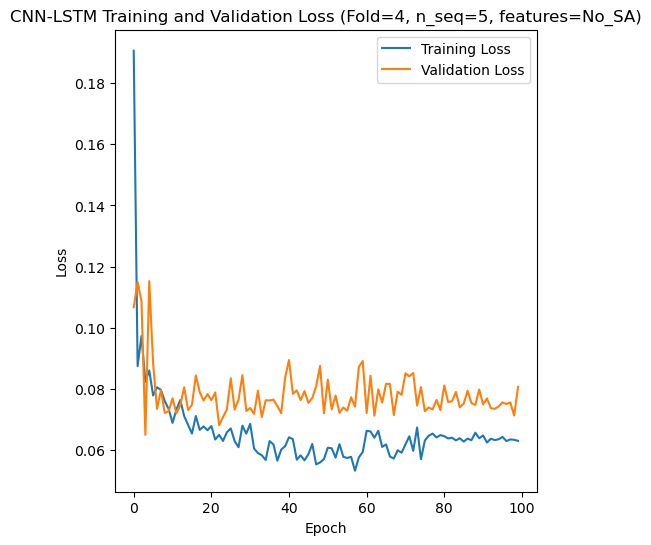

[[0.31415963048028894], [0.30245795201282616], [0.47587437867925864], [0.2890145806189788], [0.39310276114858567]]
[[array(0.31415963)], [array(0.30245795)], [array(0.47587438)], [array(0.28901458)], [array(0.39310276)]]
[[0.2692673275172712], [0.2526332732439041], [0.40993242856860174], [0.21145343314111198], [0.33733141693472907]]
[[0.023663295594233524], [0.027759668707163156], [0.04861749651735655], [0.0375604341570691], [0.0345754069355839]]
[[0.9597526700346655], [0.9716849903505134], [0.43558604599084116], [0.9721678418216396], [0.9506371749516954]]
[[array(0.0236633)], [array(0.02775967)], [array(0.0486175)], [array(0.03756043)], [array(0.03457541)]]
[[array(0.98289317)], [array(0.98182814)], [array(0.81383997)], [array(0.98523451)], [array(0.99222717)]]
[12.77 12.89 12.7  12.41 12.72  9.88 10.09  9.65  9.13  9.32 10.8  11.16
 10.49 10.54 10.4   7.66  6.92  7.36  6.79  6.94  9.64  9.11  8.7   8.6
  8.87  7.84  7.66  7.73  8.    8.01  4.55  4.9   4.44  4.05  4.62  8.21
  8.12  8

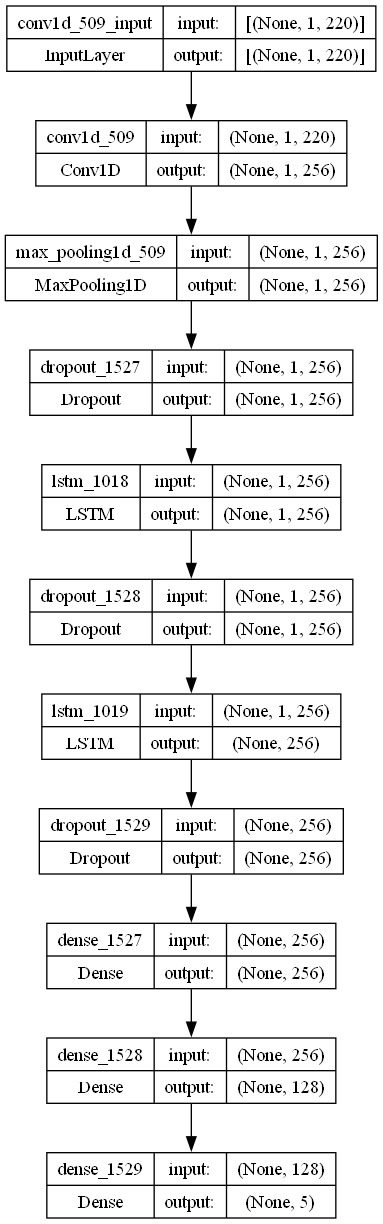

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 256
    lr = 0.0016097723085038492
    optimizer = Adam(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 256
    dropout_rate = 0.165344441432353

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

   
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_SH_S5_No_SA.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)